In [1]:
!pip install pycaret 
! pip install optuna 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.2 MB/s

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 

In [3]:
from cycler import cycler


raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]


light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2]
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2]
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

mpl.rcParams['figure.dpi'] = 200

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [4]:
def calculate_apfd(faults_detected_order):
    num_faults = len(faults_detected_order)
    total_tests = sum(range(1, num_faults + 1))
    
    if num_faults == 0:
        return 0.0

    detected_positions = [i + 1 for i in faults_detected_order]
    apfd = 1 - (sum(detected_positions) / total_tests) + (num_faults / (2 * total_tests))
    
    return apfd
    
def calculate_apfd_from_probabilities(predicted_probabilities):
    # Assuming predicted_probabilities is a list of lists containing probabilities for each class
    num_classes = len(predicted_probabilities[0])
    num_tests = len(predicted_probabilities)

    # Sort the probabilities in descending order for each test
    sorted_probabilities = [sorted(enumerate(prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]

    # Create a list to store the order in which faults are detected
    faults_detected_order = []

    for i in range(num_tests):
        # Add the index of the detected fault (class) to the order list
        detected_fault_index = [index for index, _ in sorted_probabilities[i]]
        faults_detected_order.append(detected_fault_index.index(1))  # Assuming class 1 is the positive class

    # Calculate and return APFD
    apfd_value = calculate_apfd(faults_detected_order)
    return apfd_value

# Example usage:
# Replace predicted_probabilities with the actual output from predict_proba()
predicted_probabilities = [[0.9, 0.1], [0.3, 0.7], [0.8, 0.2]]
apfd_value = calculate_apfd_from_probabilities(predicted_probabilities)

print(f"APFD: {apfd_value}")



APFD: 0.41666666666666663


## EDA

In [5]:
data=pd.read_csv("/kaggle/input/tcp-data/dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30425 entries, 0 to 30424
Columns: 156 entries, Build to DET_COV_IMP_Faults
dtypes: float64(150), int64(6)
memory usage: 36.2 MB


In [6]:
data

,Build,Test,Verdict,Duration,TES_COM_CountDeclFunction,TES_COM_CountLine,TES_COM_CountLineBlank,TES_COM_CountLineCode,TES_COM_CountLineCodeDecl,TES_COM_CountLineCodeExe,...,COD_COV_PRO_IMP_AllCommitersExperience,COD_COV_CHN_C_LinesAdded,COD_COV_CHN_C_LinesDeleted,COD_COV_CHN_C_AddedChangeScattering,COD_COV_CHN_C_DeletedChangeScattering,COD_COV_CHN_C_DMMSize,COD_COV_CHN_C_DMMComplexity,COD_COV_CHN_C_DMMInterfacing,DET_COV_C_Faults,DET_COV_IMP_Faults
0,115071710,24123,0,82,13.0,203.0,42.0,105.0,34.0,63.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,115071710,24129,0,375,10.0,187.0,43.0,103.0,33.0,68.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,115071710,24130,0,783,21.0,496.0,122.0,307.0,118.0,250.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,115071710,24131,0,1583,24.0,623.0,139.0,395.0,72.0,332.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,115071710,24132,0,1888,19.0,411.0,86.0,261.0,71.0,189.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30420,128866605,19499,0,124,5.0,184.0,51.0,116.0,49.0,85.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30421,128866605,19662,0,3,5.0,276.0,30.0,186.0,41.0,161.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30422,128866605,19678,0,296,36.0,532.0,159.0,350.0,105.0,240.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30423,128866605,19701,0,1979,25.0,830.0,223.0,534.0,187.0,433.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [7]:
data.isna().sum().sum()

0

there is no null data 

In [8]:
data['Verdict'].value_counts()
# 0 is successful
# 1 failure exception
# 2 failure assert

0    29215
1     1172
2       38
Name: Verdict, dtype: int64

In [9]:
data['Verdict']=data['Verdict'].replace({ 2:1 })
data['Verdict']=data['Verdict'].replace({ 0:1,1:0 })
data['Verdict'].value_counts()

1    29215
0     1210
Name: Verdict, dtype: int64

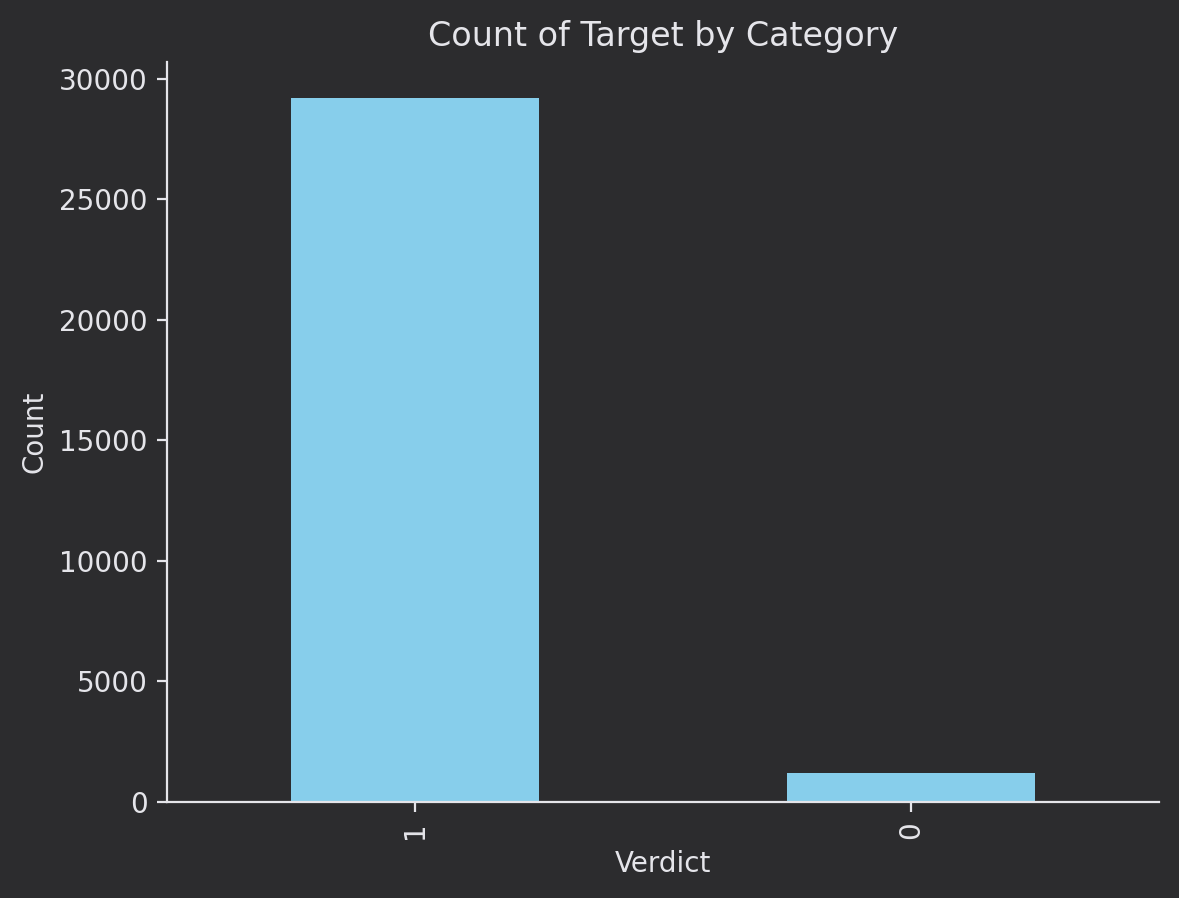

In [10]:
count_plot = data['Verdict'].value_counts().plot(kind='bar', color='skyblue')
count_plot.set_xlabel('Verdict')
count_plot.set_ylabel('Count')
count_plot.set_title('Count of Target by Category')
plt.show()

The number of fallout cases is significantly lower than the successful ones. Therefore, we need to address this imbalance. For instance, we might consider using SMOTE to handle the unbalanced data.

In [11]:
data.describe().T.style.bar(subset=['std'])

,count,mean,std,min,25%,50%,75%,max
Build,30425.000000,121969052.672243,4013784.009736,115071710.000000,119757362.000000,122449871.000000,125006475.000000,128866605.000000
Test,30425.000000,21842.092654,4892.924376,1769.000000,17427.000000,22611.000000,25394.000000,28921.000000
Verdict,30425.000000,0.960230,0.195421,0.000000,1.000000,1.000000,1.000000,1.000000
Duration,30425.000000,1257.278915,4232.930111,0.000000,42.000000,290.000000,1085.000000,158215.000000
TES_COM_CountDeclFunction,30425.000000,16.279037,25.454098,1.000000,4.000000,11.000000,16.279037,412.000000
TES_COM_CountLine,30425.000000,399.600087,587.053385,24.000000,107.000000,246.000000,399.600087,8735.000000
TES_COM_CountLineBlank,30425.000000,85.113886,130.418985,4.000000,20.000000,49.000000,85.113886,1923.000000
TES_COM_CountLineCode,30425.000000,259.988643,383.118697,9.000000,65.000000,155.000000,259.988643,5374.000000
TES_COM_CountLineCodeDecl,30425.000000,90.043164,113.330752,5.000000,29.000000,56.000000,90.043164,1310.000000
TES_COM_CountLineCodeExe,30425.000000,194.117460,312.252411,0.000000,37.000000,105.000000,194.117460,4419.000000


In [12]:
import umap.umap_ as umap

train_sub = data
target = train_sub['Verdict']
umap = umap.UMAP(random_state=0)
dr = umap.fit_transform(train_sub.iloc[:,:-1], target)

2024-02-17 16:57:38.803083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 16:57:38.803242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 16:57:38.981366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: 

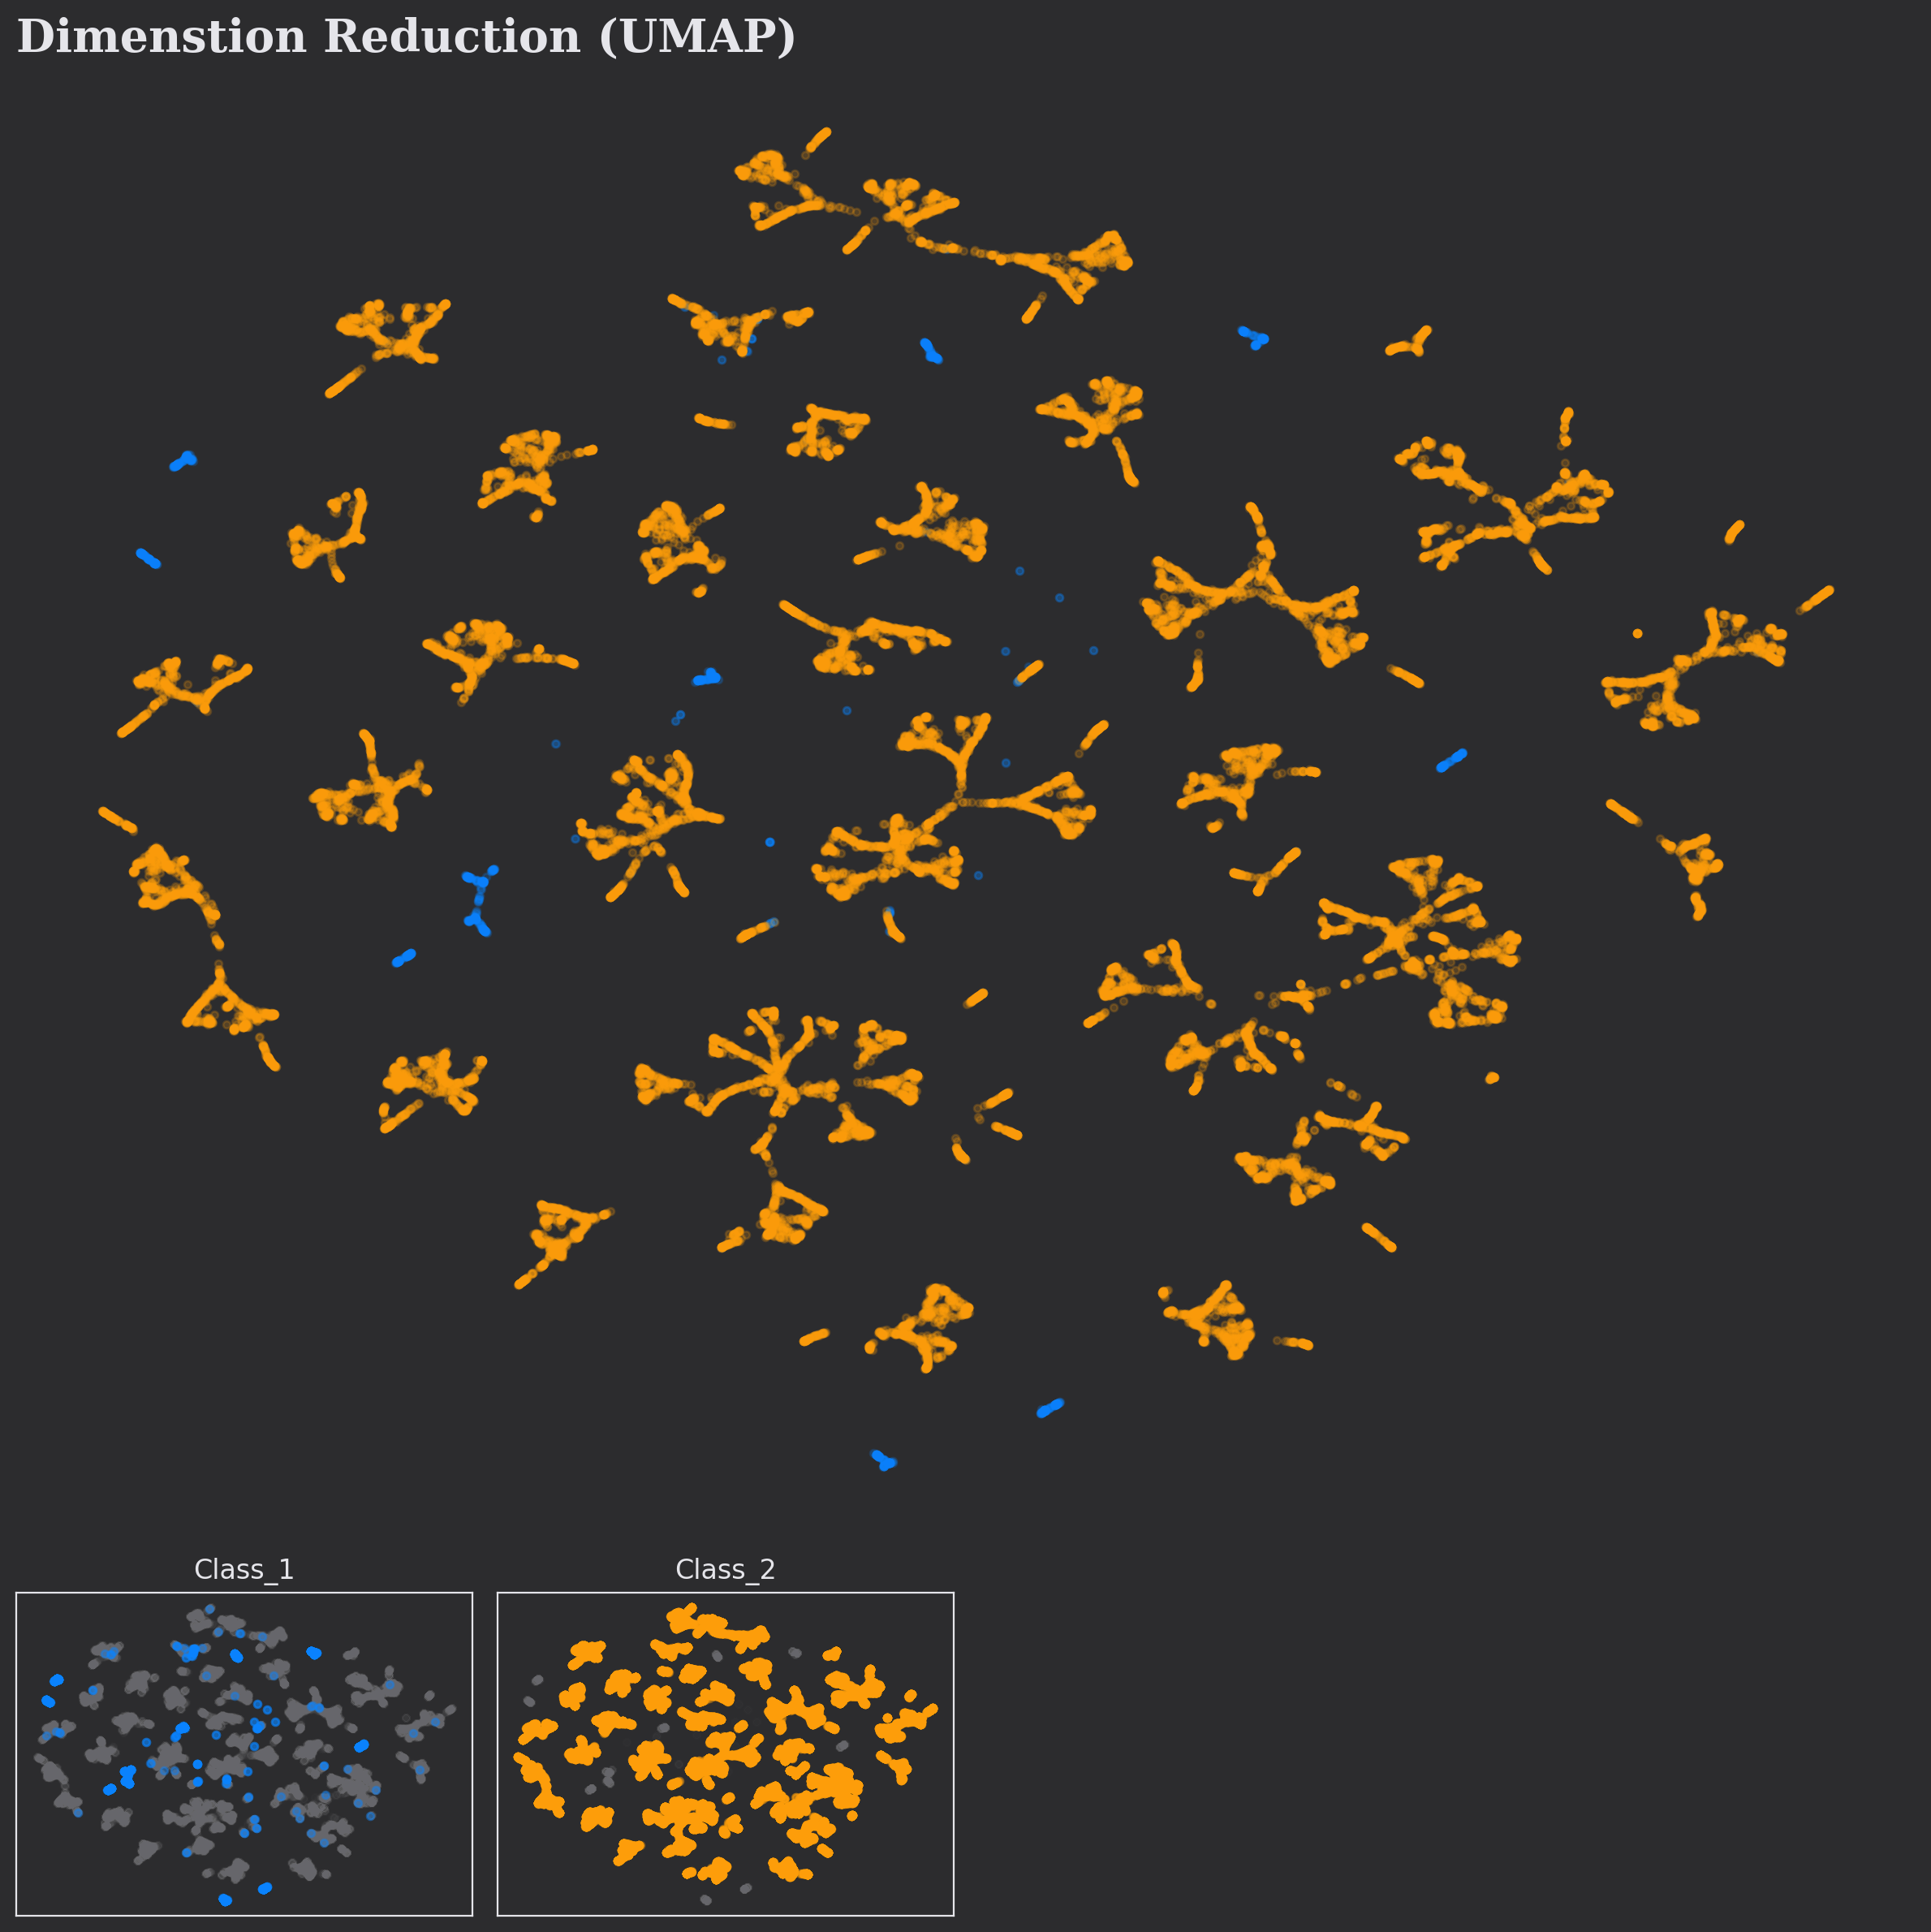

In [13]:
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(5, 4)
ax = fig.add_subplot(gs[:-1,:])

sub_axes = [None] * 2
for idx in range(2): 
    sub_axes[idx] = fig.add_subplot(gs[-1,idx])

for idx in range(2):
    ax.scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
              s=10, alpha=0.2
              )

    for j in range(2):
        sub_axes[j].scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
                              s=10, alpha = 0.4 if idx==j else 0.008, color = (dark_palette[j%9]) if idx==j else white_color,
                            zorder=(idx==j)
                           )
        
    
    sub_axes[idx].set_xticks([])
    sub_axes[idx].set_yticks([])
    sub_axes[idx].set_xlabel('')
    sub_axes[idx].set_ylabel('')
    sub_axes[idx].set_title(f'Class_{idx+1}')
    sub_axes[idx].spines['right'].set_visible(True)
    sub_axes[idx].spines['top'].set_visible(True)
    
ax.set_title('Dimenstion Reduction (UMAP)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')  
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout()
plt.show()

The umap has successfully divide the data into two class without many overlabs.

## modeling 

In [14]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def calculate_apfd(faults_detected_order):
    num_faults = len(faults_detected_order)
    total_tests = sum(range(1, num_faults + 1))
    
    if num_faults == 0:
        return 0.0

    detected_positions = [i + 1 for i in faults_detected_order]
    apfd = 1 - (sum(detected_positions) / total_tests) + (num_faults / (2 * total_tests))
    
    return apfd
    
def calculate_apfd_from_probabilities(predicted_probabilities):
    # Assuming predicted_probabilities is a list of lists containing probabilities for each class
    num_classes = len(predicted_probabilities[0])
    num_tests = len(predicted_probabilities)

    # Sort the probabilities in descending order for each test
    sorted_probabilities = [sorted(enumerate(prob), key=lambda x: x[1], reverse=True) for prob in predicted_probabilities]

    # Create a list to store the order in which faults are detected
    faults_detected_order = []

    for i in range(num_tests):
        # Add the index of the detected fault (class) to the order list
        detected_fault_index = [index for index, _ in sorted_probabilities[i]]
        faults_detected_order.append(detected_fault_index.index(1))  # Assuming class 1 is the positive class

    # Calculate and return APFD
    apfd_value = calculate_apfd(faults_detected_order)
    return apfd_value

def display_scores(y_true, y_pred):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_preds(y_true, y_pred, name):
    
    # Additional metrics for binary classification
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    metrics = {'model': name,
               'F1 Score': f1,
               'MCC': mcc,
                }
    display_scores(y_true, y_pred)
    return metrics


In [15]:
data.drop(['Build','Test','Duration'],axis=1,inplace=True)
data

,Verdict,TES_COM_CountDeclFunction,TES_COM_CountLine,TES_COM_CountLineBlank,TES_COM_CountLineCode,TES_COM_CountLineCodeDecl,TES_COM_CountLineCodeExe,TES_COM_CountLineComment,TES_COM_CountStmt,TES_COM_CountStmtDecl,...,COD_COV_PRO_IMP_AllCommitersExperience,COD_COV_CHN_C_LinesAdded,COD_COV_CHN_C_LinesDeleted,COD_COV_CHN_C_AddedChangeScattering,COD_COV_CHN_C_DeletedChangeScattering,COD_COV_CHN_C_DMMSize,COD_COV_CHN_C_DMMComplexity,COD_COV_CHN_C_DMMInterfacing,DET_COV_C_Faults,DET_COV_IMP_Faults
0,1,13.0,203.0,42.0,105.0,34.0,63.0,56.0,79.0,34.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,10.0,187.0,43.0,103.0,33.0,68.0,41.0,90.0,35.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1,21.0,496.0,122.0,307.0,118.0,250.0,67.0,253.0,107.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,24.0,623.0,139.0,395.0,72.0,332.0,89.0,367.0,74.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1,19.0,411.0,86.0,261.0,71.0,189.0,64.0,230.0,80.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30420,1,5.0,184.0,51.0,116.0,49.0,85.0,17.0,101.0,44.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30421,1,5.0,276.0,30.0,186.0,41.0,161.0,60.0,63.0,36.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30422,1,36.0,532.0,159.0,350.0,105.0,240.0,23.0,285.0,83.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
30423,1,25.0,830.0,223.0,534.0,187.0,433.0,73.0,427.0,166.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


### Auto ML

In [16]:
from pycaret.classification import *
setup(data =data, 
      target = 'Verdict',
      numeric_imputation = 'median',
      fold=6
     )

,Description,Value
0,Session id,1818
1,Target,Verdict
2,Target type,Binary
3,Original data shape,"(30425, 153)"
4,Transformed data shape,"(30425, 153)"
5,Transformed train set shape,"(21297, 153)"
6,Transformed test set shape,"(9128, 153)"
7,Numeric features,152
8,Preprocess,True
9,Imputation type,simple


In [17]:
best_model = compare_models(sort = 'MCC', n_select = 3) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9976,0.9893,0.9997,0.9978,0.9988,0.9679,0.9682,23.4350
rf,Random Forest Classifier,0.9976,0.9884,0.9998,0.9977,0.9987,0.9672,0.9676,4.8933
xgboost,Extreme Gradient Boosting,0.9975,0.9935,0.9997,0.9978,0.9987,0.9666,0.9669,3.4700
lightgbm,Light Gradient Boosting Machine,0.9975,0.9935,0.9996,0.9979,0.9987,0.9667,0.9669,3.2833
et,Extra Trees Classifier,0.9975,0.9882,0.9996,0.9978,0.9987,0.9660,0.9663,3.3450
gbc,Gradient Boosting Classifier,0.9966,0.9872,0.9986,0.9979,0.9982,0.9553,0.9554,17.2800
ada,Ada Boost Classifier,0.9958,0.9859,0.9987,0.9970,0.9978,0.9442,0.9445,4.6117
dt,Decision Tree Classifier,0.9955,0.9728,0.9975,0.9978,0.9977,0.9413,0.9414,1.5450
lda,Linear Discriminant Analysis,0.9877,0.9727,0.9906,0.9966,0.9936,0.8496,0.8519,1.3100
knn,K Neighbors Classifier,0.9805,0.9621,0.9911,0.9886,0.9899,0.7372,0.7378,2.0700


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

IUsing AutoML can be a helpful approach to quickly explore and identify suitable algorithms for our machine learning task.

As observed, tree-based algorithms have yielded optimal results; consequently, we intend to use them.



In [18]:
catboost = create_model('catboost')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9966,0.9759,0.9994,0.9971,0.9982,0.9544,0.9549
1,0.9983,0.9949,0.9997,0.9985,0.9991,0.9775,0.9776
2,0.9972,0.9887,0.9997,0.9974,0.9985,0.9623,0.9627
3,0.9975,0.9952,0.9997,0.9977,0.9987,0.9660,0.9663
4,0.9969,0.9839,0.9997,0.9971,0.9984,0.9581,0.9587
5,0.9992,0.9972,1.0000,0.9991,0.9996,0.9888,0.9889
Mean,0.9976,0.9893,0.9997,0.9978,0.9988,0.9679,0.9682
Std,0.0009,0.0075,0.0002,0.0008,0.0005,0.0118,0.0117


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

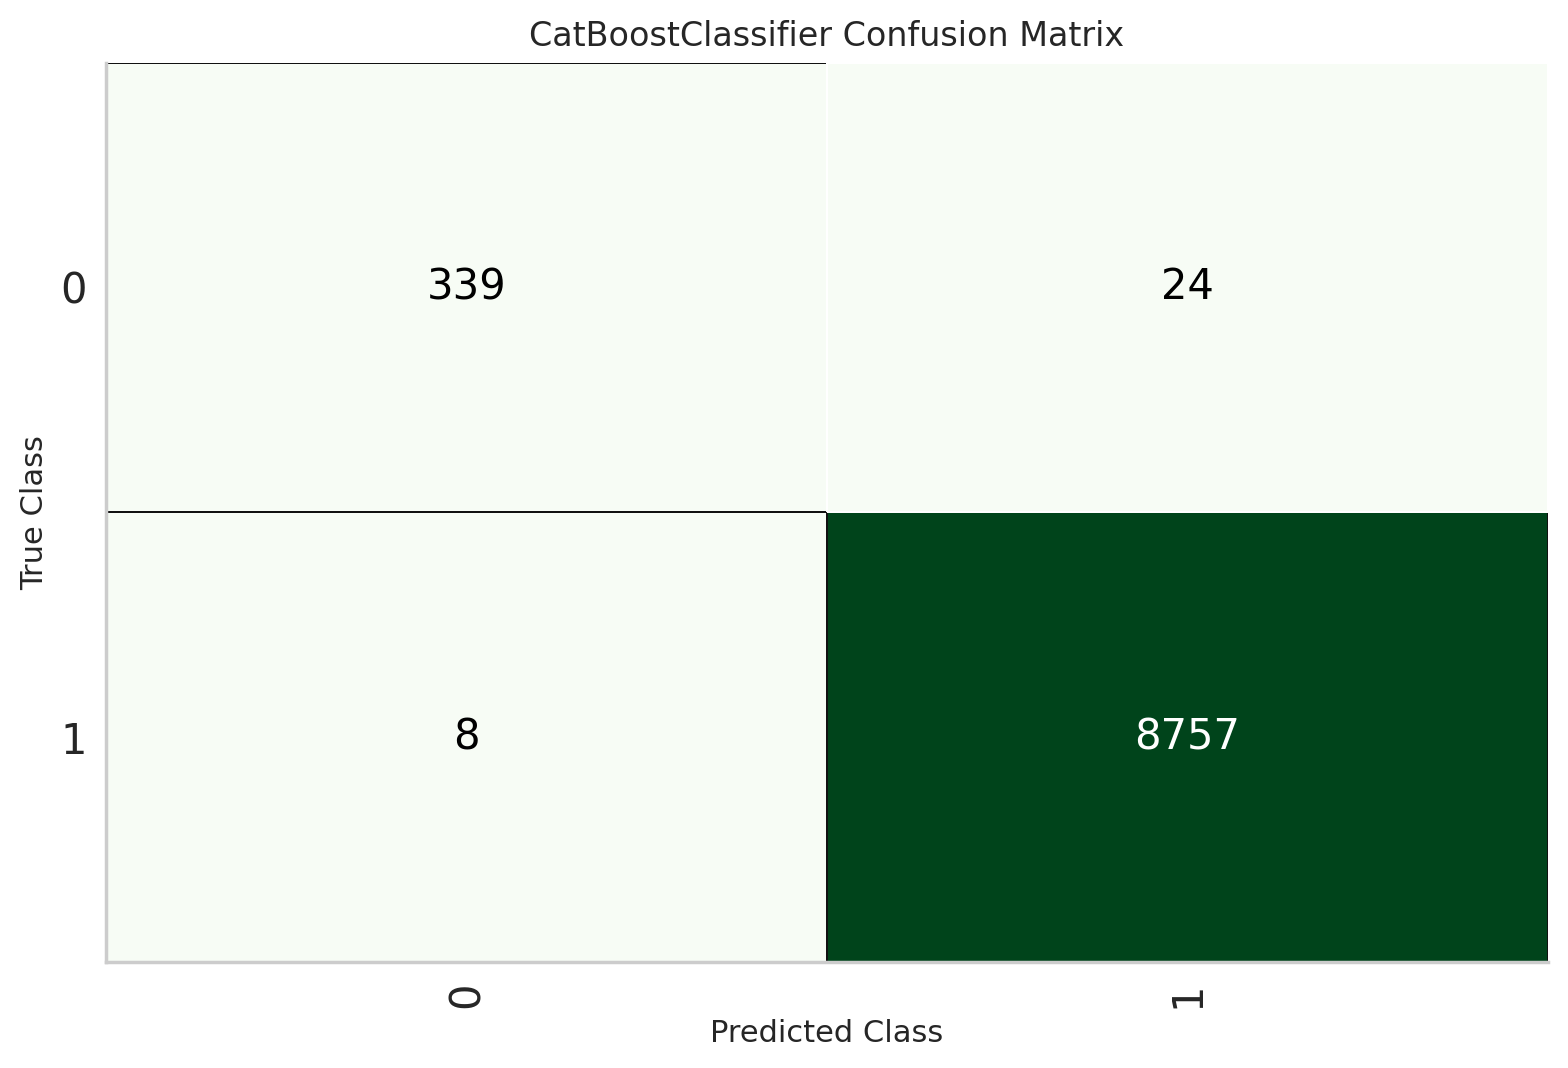

In [19]:
plot_model(catboost, plot = 'confusion_matrix')

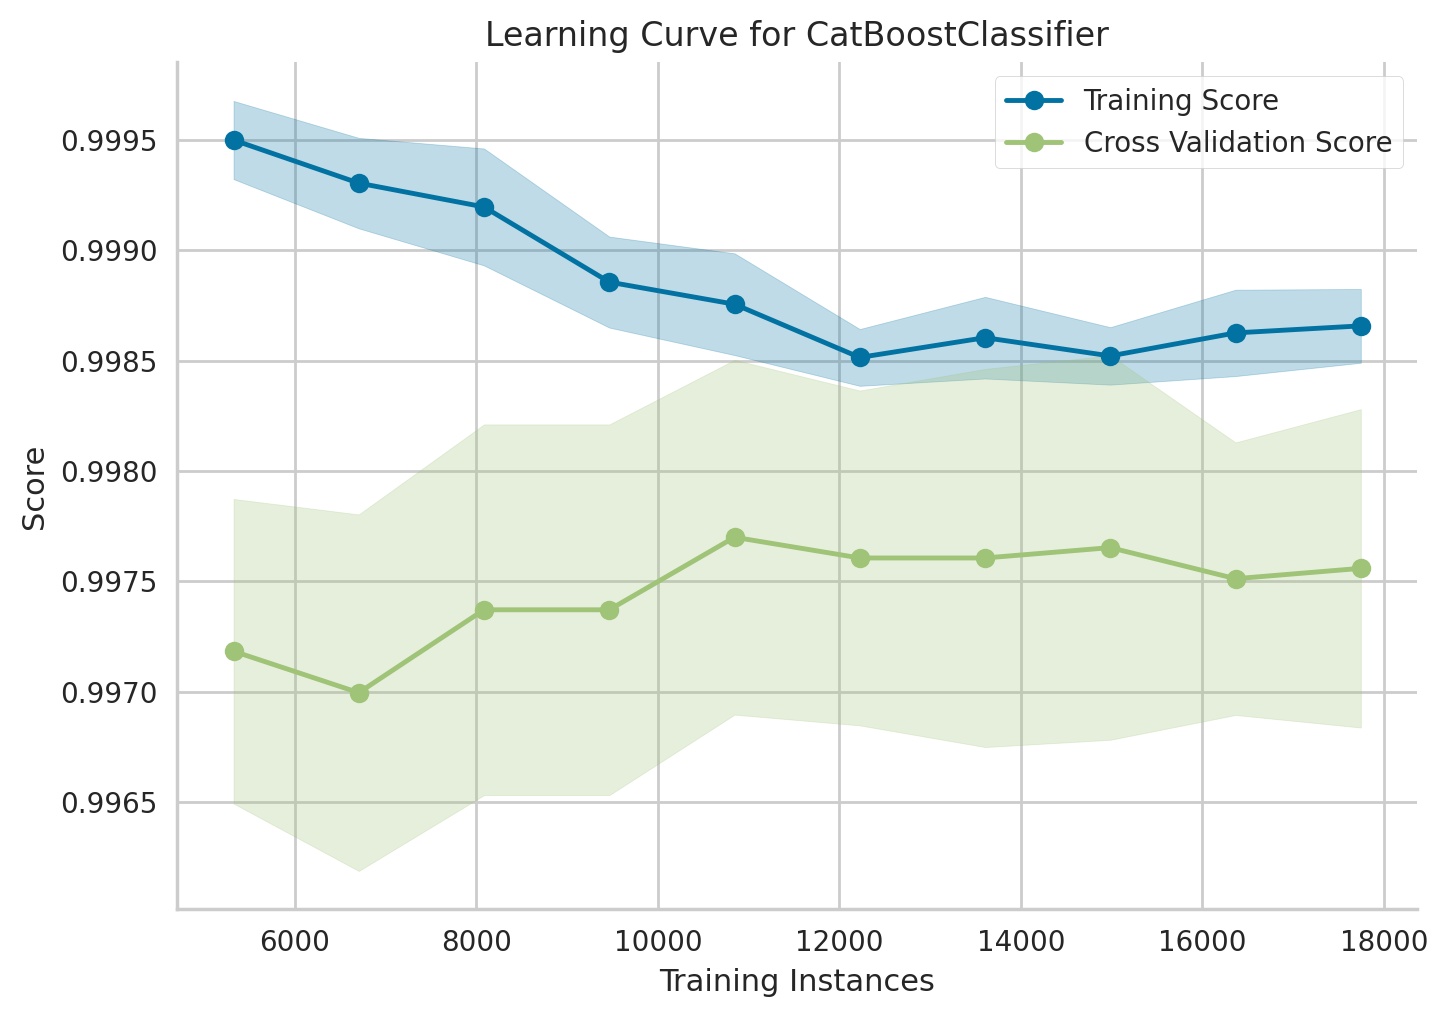

In [20]:
plot_model(catboost, plot = 'learning')

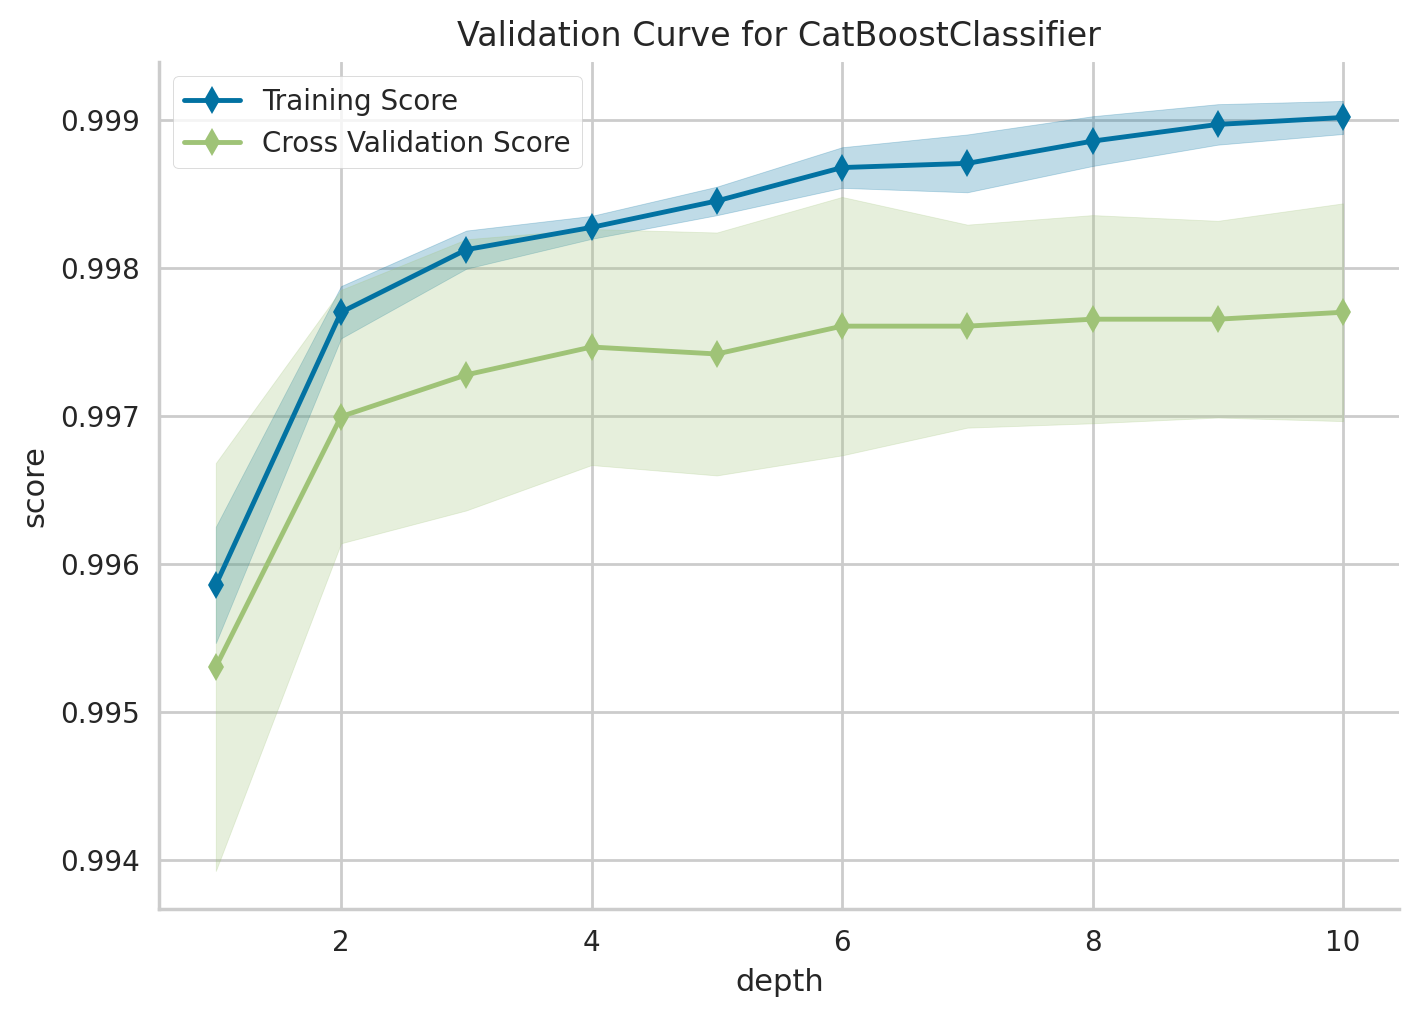

In [21]:
plot_model(catboost, plot = 'vc')

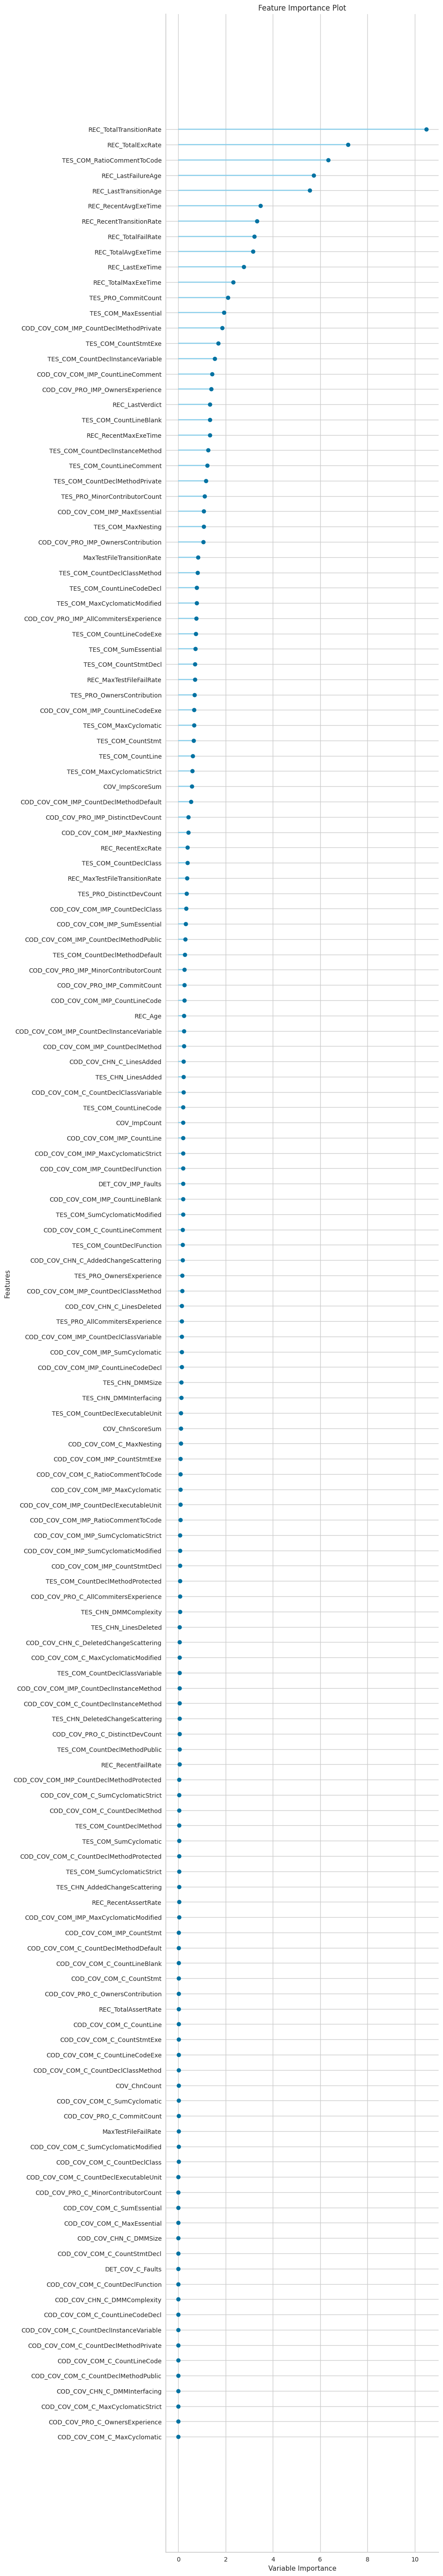

In [22]:
plot_model(catboost, plot = 'feature_all')

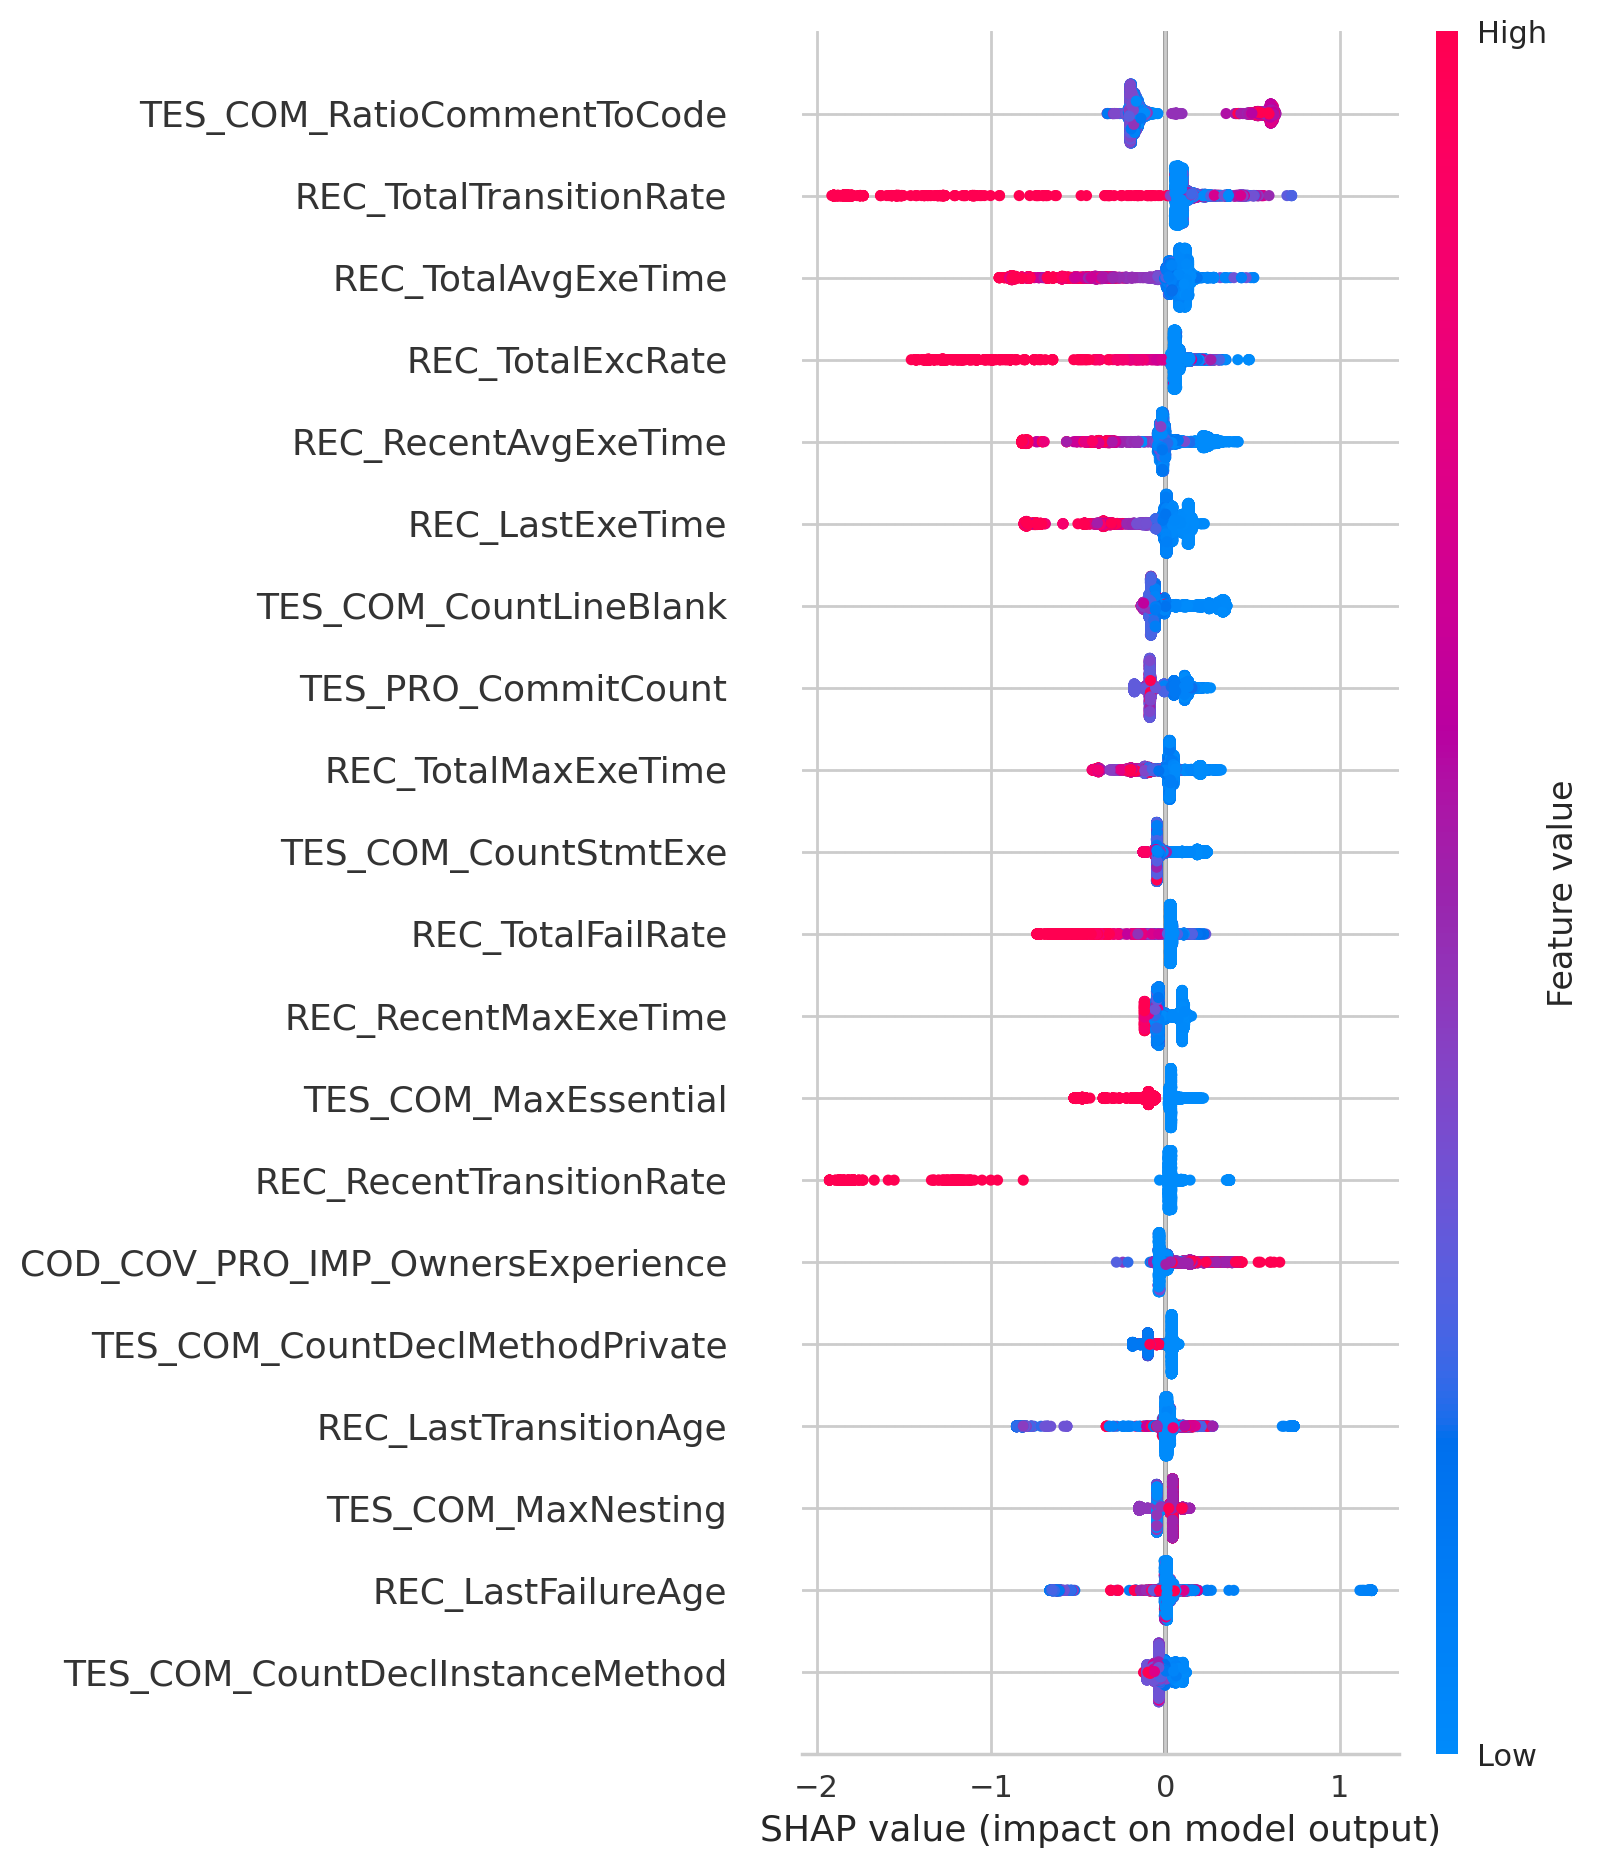

In [23]:
interpret_model(catboost)

### ML

In [24]:
training = pd.DataFrame(index=None, columns=['model','F1 Score','MCC'])
testing=pd.DataFrame(index=None, columns=['model','F1 Score','MCC'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
data.drop('Verdict',axis=1), data['Verdict'], test_size=0.2, random_state=42)
feature_name=X_train.columns

X=data.drop('Verdict',axis=1)
y=data['Verdict']

In [25]:
from sklearn.ensemble import ExtraTreesClassifier #finding the best features

TOP_FEATURES = 75

forest = ExtraTreesClassifier(n_estimators=250, max_depth=10, random_state=1)
forest.fit(X_train,y_train)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print('{}.feature {} ({})' .format(f + 1, feature_name[indices[f]], importances[indices[f]]))

Top features:
1.feature MaxTestFileTransitionRate (0.08913263621417997)
2.feature TES_COM_CountDeclMethodDefault (0.08081205293144822)
3.feature MaxTestFileFailRate (0.0686064379834626)
4.feature REC_MaxTestFileFailRate (0.06534521571598599)
5.feature REC_MaxTestFileTransitionRate (0.055640051407214605)
6.feature REC_TotalAvgExeTime (0.05453440589112485)
7.feature REC_RecentAvgExeTime (0.0502405361522797)
8.feature REC_TotalTransitionRate (0.04830418036002902)
9.feature TES_COM_MaxEssential (0.04161656830212011)
10.feature REC_LastExeTime (0.03176802519888828)
11.feature REC_RecentMaxExeTime (0.026568488959456397)
12.feature TES_PRO_OwnersExperience (0.026002602072196748)
13.feature REC_RecentTransitionRate (0.023926770135844676)
14.feature REC_RecentExcRate (0.016806562585077994)
15.feature REC_TotalFailRate (0.016339799865622492)
16.feature REC_LastTransitionAge (0.015852084254774246)
17.feature REC_LastFailureAge (0.013149869723640477)
18.feature REC_LastVerdict (0.01247306076882853

In [26]:
X_train = X_train.iloc[:, indices]
X_test = X_test.iloc[:, indices]
X=X.iloc[:, indices]

In [27]:
X_train

,MaxTestFileTransitionRate,TES_COM_CountDeclMethodDefault,MaxTestFileFailRate,REC_MaxTestFileFailRate,REC_MaxTestFileTransitionRate,REC_TotalAvgExeTime,REC_RecentAvgExeTime,REC_TotalTransitionRate,TES_COM_MaxEssential,REC_LastExeTime,...,COD_COV_COM_IMP_CountDeclFunction,COD_COV_PRO_IMP_MinorContributorCount,COD_COV_COM_IMP_CountDeclClassMethod,COD_COV_PRO_IMP_OwnersExperience,TES_CHN_LinesAdded,COD_COV_PRO_IMP_AllCommitersExperience,COD_COV_COM_IMP_MaxCyclomaticModified,TES_CHN_DMMSize,COD_COV_COM_IMP_CountDeclMethod,COD_COV_COM_IMP_CountLineCodeExe
12217,-1.0,0.000000,-1.0,-1.0,-1.0,54.544688,23.833333,0.000000,1.000000,20.0,...,9.321708,0.390465,0.00659,43.104382,-1.0,24.352189,0.12824,-1.0,9.321708,9.276652
27541,-1.0,0.000000,-1.0,-1.0,-1.0,35.219368,20.166667,0.000000,1.000000,20.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
24317,-1.0,0.000000,-1.0,-1.0,-1.0,110.227991,213.000000,0.000000,1.000000,82.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
29340,-1.0,0.000000,-1.0,-1.0,-1.0,5134.058670,654.500000,0.000000,1.000000,702.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
30154,-1.0,0.003892,-1.0,-1.0,-1.0,1517.603448,820.833333,0.000000,1.142596,656.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,-1.0,0.003892,-1.0,-1.0,-1.0,6.471698,5.333333,0.000000,1.142596,4.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
5390,-1.0,0.000000,-1.0,-1.0,-1.0,44.598859,31.000000,0.000000,1.000000,37.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
860,1.0,0.000000,0.5,0.5,0.5,341.618357,346.333333,0.009662,1.000000,284.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000
15795,-1.0,0.000000,-1.0,-1.0,-1.0,83.657364,71.833333,0.000000,1.000000,252.0,...,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000


Class distribution after SMOTE: Counter({1: 23370, 0: 23370})


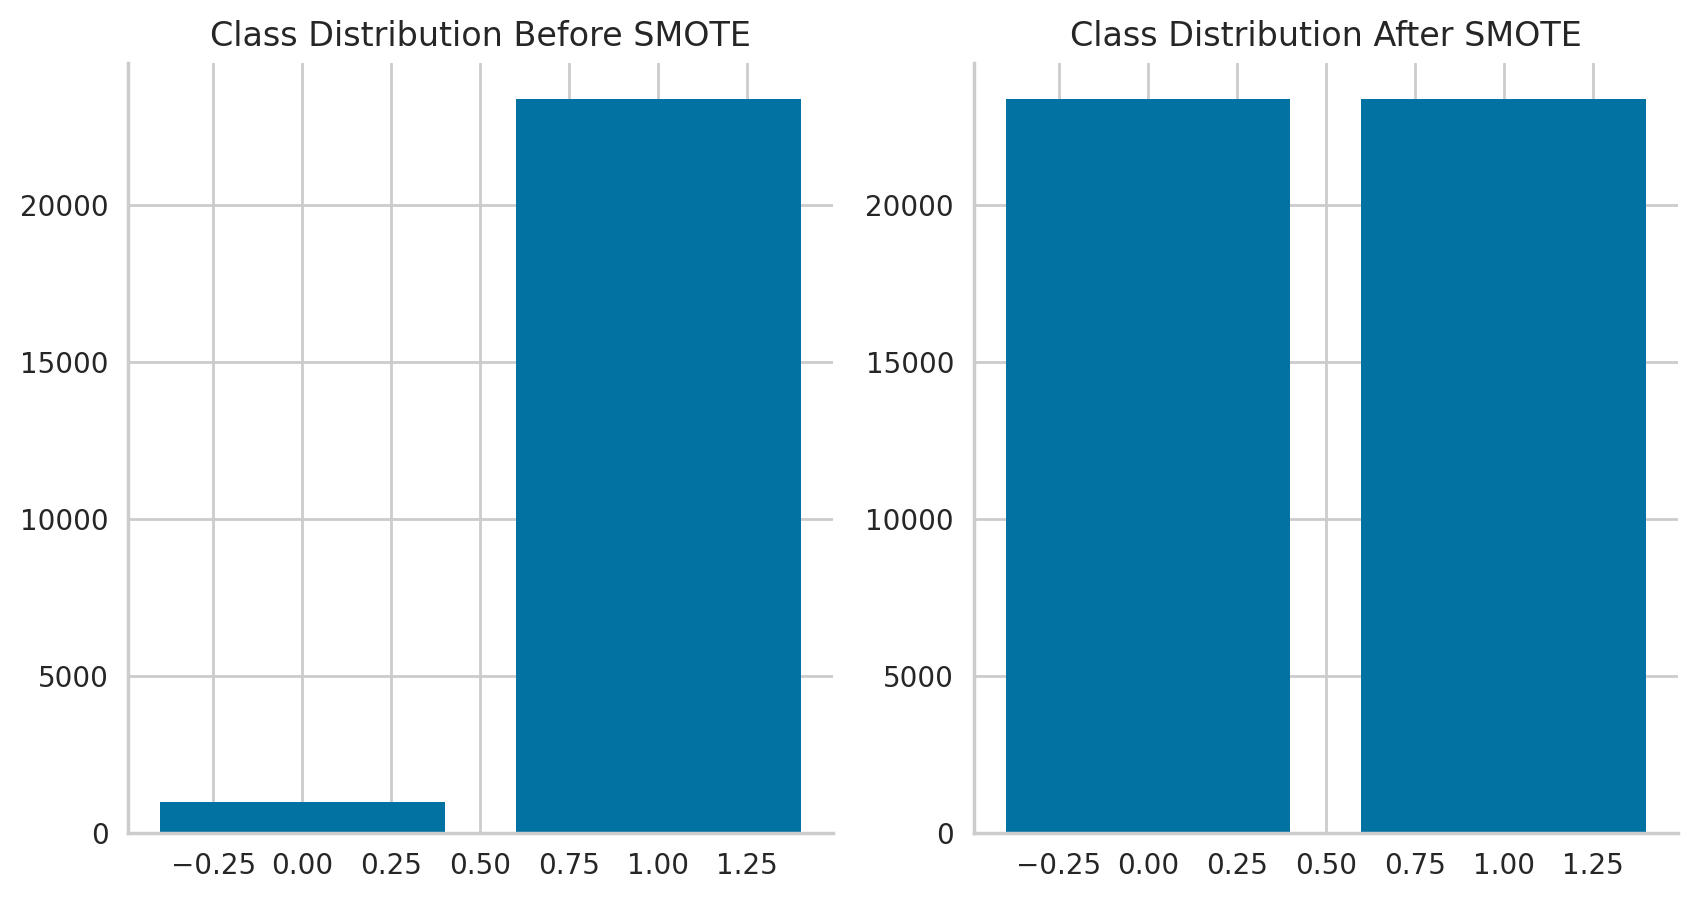

In [28]:
from imblearn.over_sampling import SMOTE
from collections import Counter
#smote 
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))

# Visualize the distribution before and after SMOTE
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(Counter(y_train).keys(), Counter(y_train).values())
plt.title("Class Distribution Before SMOTE")

plt.subplot(1, 2, 2)
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title("Class Distribution After SMOTE")

plt.show()

In [29]:
X_train,y_train = X_resampled,y_resampled

#### LogisticRegression

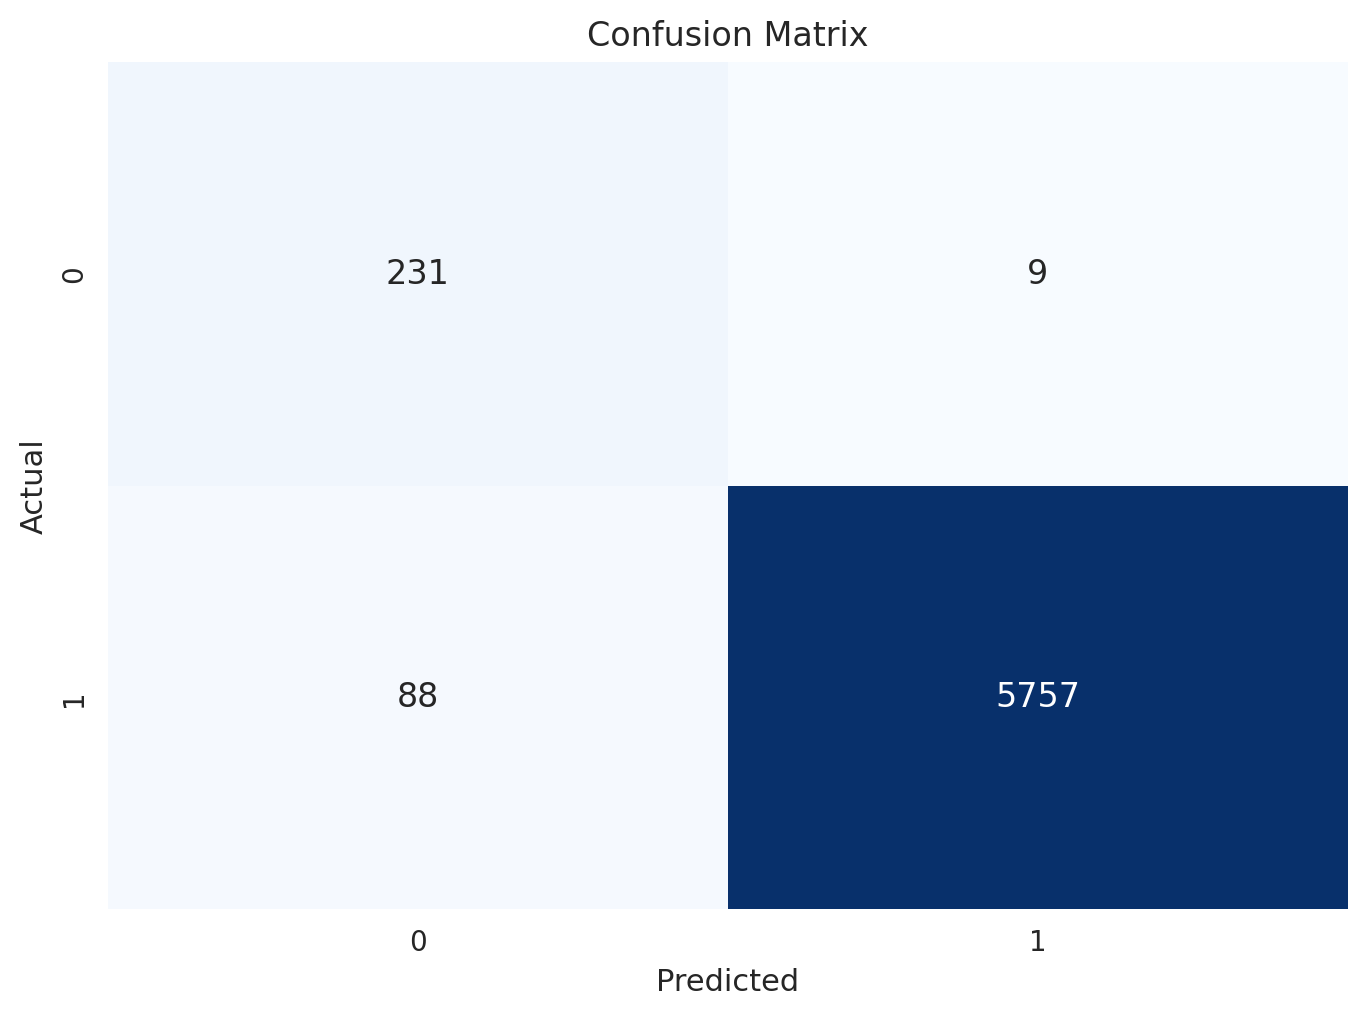

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407


In [30]:
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

sc=StandardScaler().fit(X_train)
X_train_sc=sc.transform(X_train)
X_test_sc=sc.transform(X_test)

log_reg=LogisticRegression().fit(X_train_sc,y_train)
pred_log=log_reg.predict(X_test_sc)
pred_log_train=log_reg.predict(X_train_sc)
logreg_res=evaluate_preds(y_test, pred_log,'LogisticRegression')
logreg_res
testing = testing._append(pd.Series(logreg_res),ignore_index=True )
testing

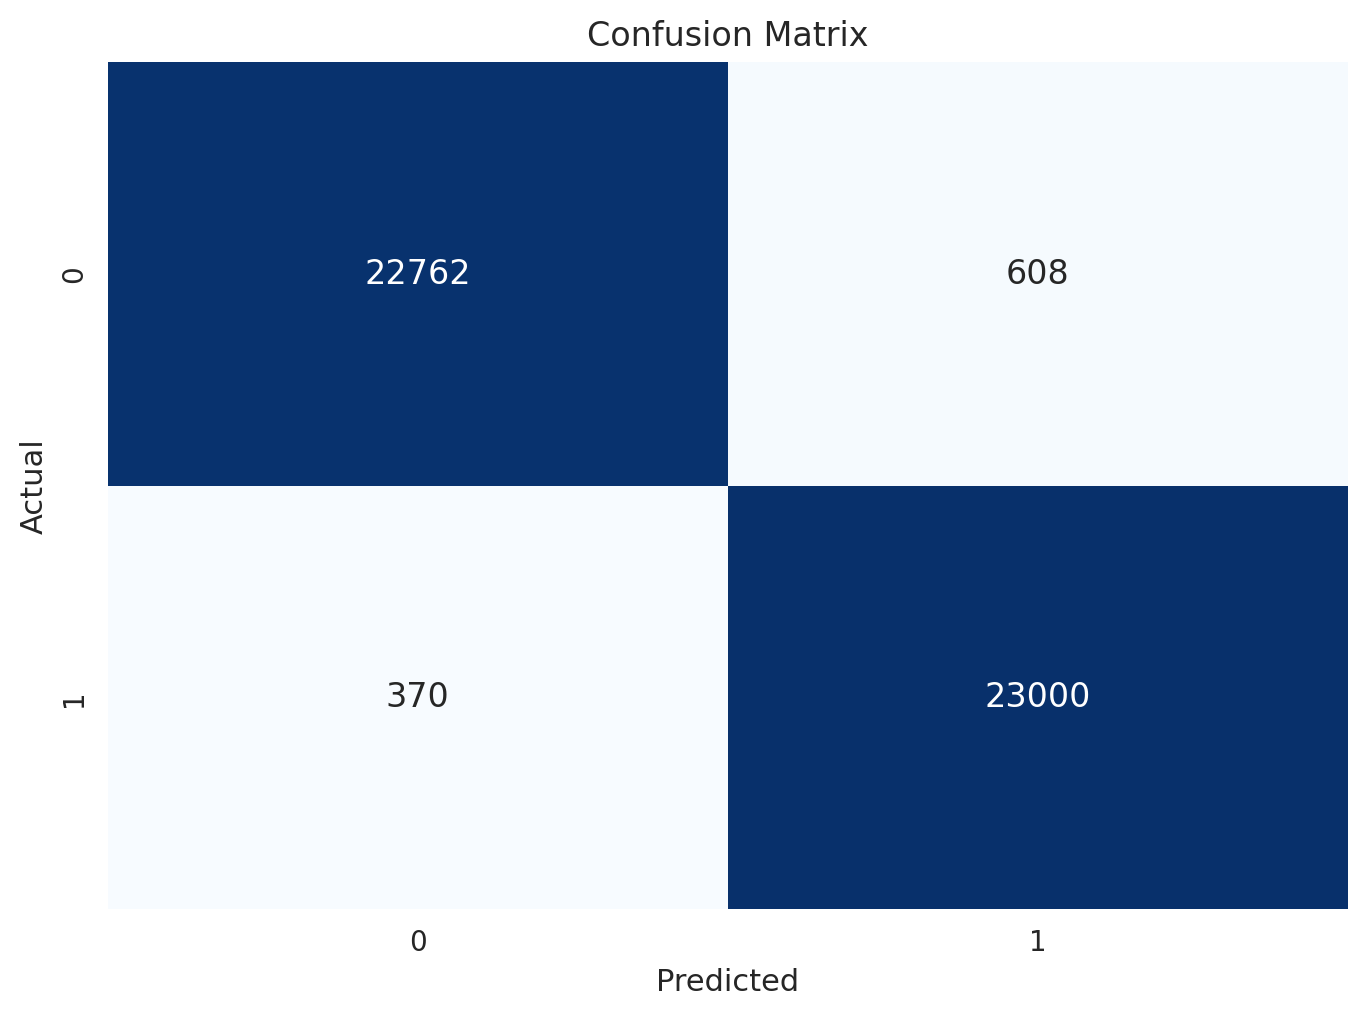

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201


In [31]:
logreg_res=evaluate_preds(y_train, pred_log_train,'LogisticRegression')
logreg_res
training = training._append(pd.Series(logreg_res),ignore_index=True )
training

In [32]:
X_sc=sc.transform(X)
log_proba=log_reg.predict_proba(X_sc)
calculate_apfd_from_probabilities(log_proba)

0.9999636506445504

#### RandomForest

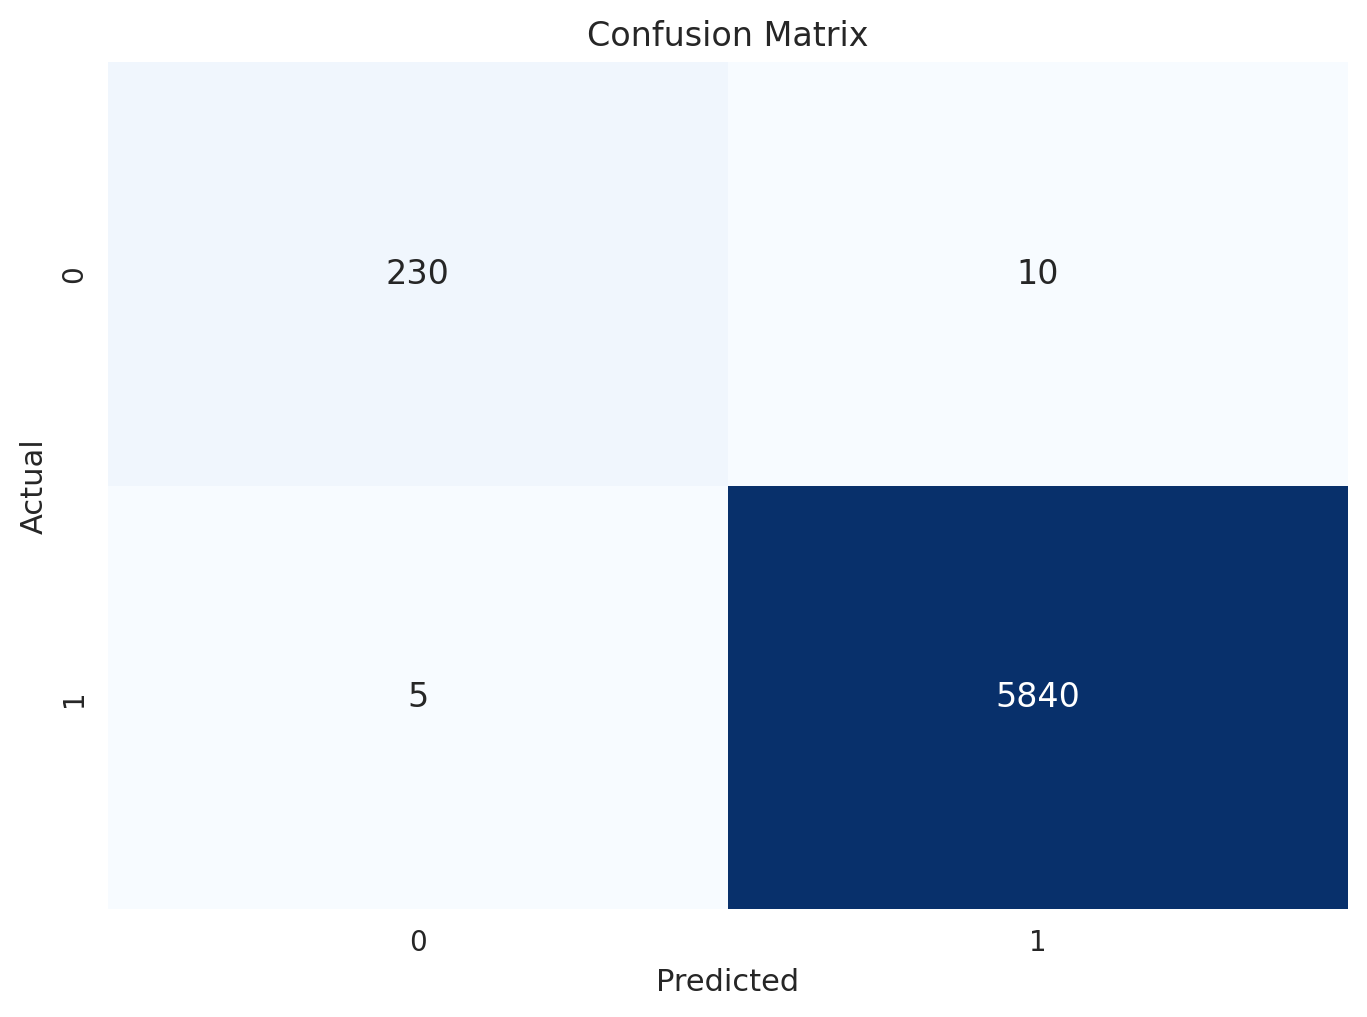

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197


In [33]:
from sklearn.ensemble import RandomForestClassifier


# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_rf = rf_classifier.predict(X_test)
pred_rf_train = rf_classifier.predict(X_train)

# Evaluate the Random Forest model
rf_res = evaluate_preds(y_test, pred_rf, 'RandomForest')


# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing._append(pd.Series(rf_res), ignore_index=True)
testing

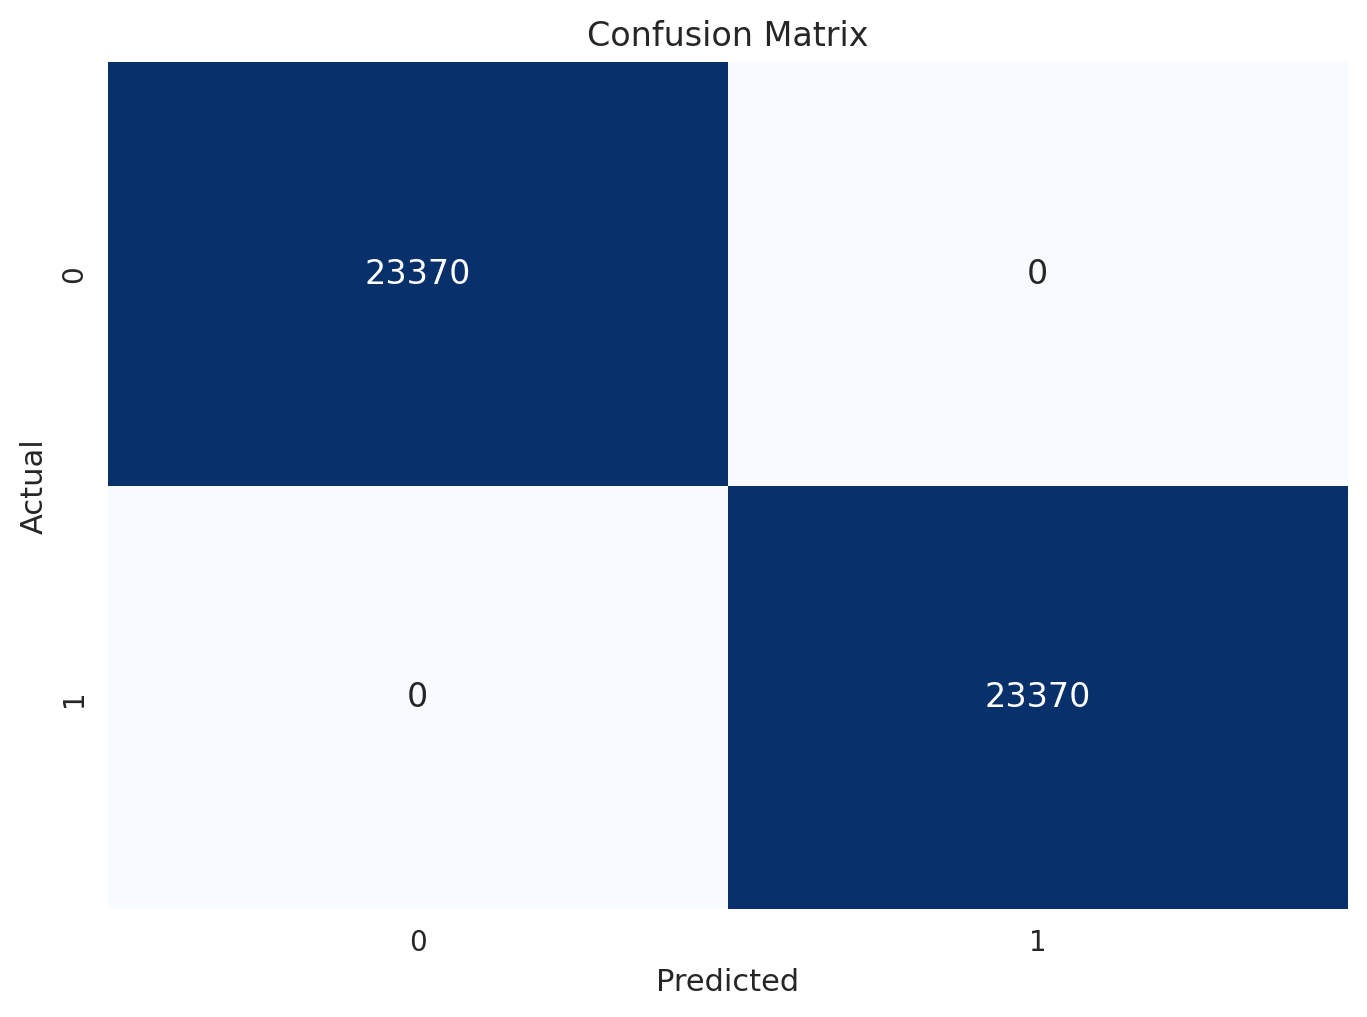

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000


In [34]:
rf_res=evaluate_preds(y_train, pred_rf_train,'RandomForest')
training = training._append(pd.Series(rf_res),ignore_index=True )
training

In [35]:
rf_proba=rf_classifier.predict_proba(X)
calculate_apfd_from_probabilities(rf_proba)

0.9999645299686116

#### NaiveBayes

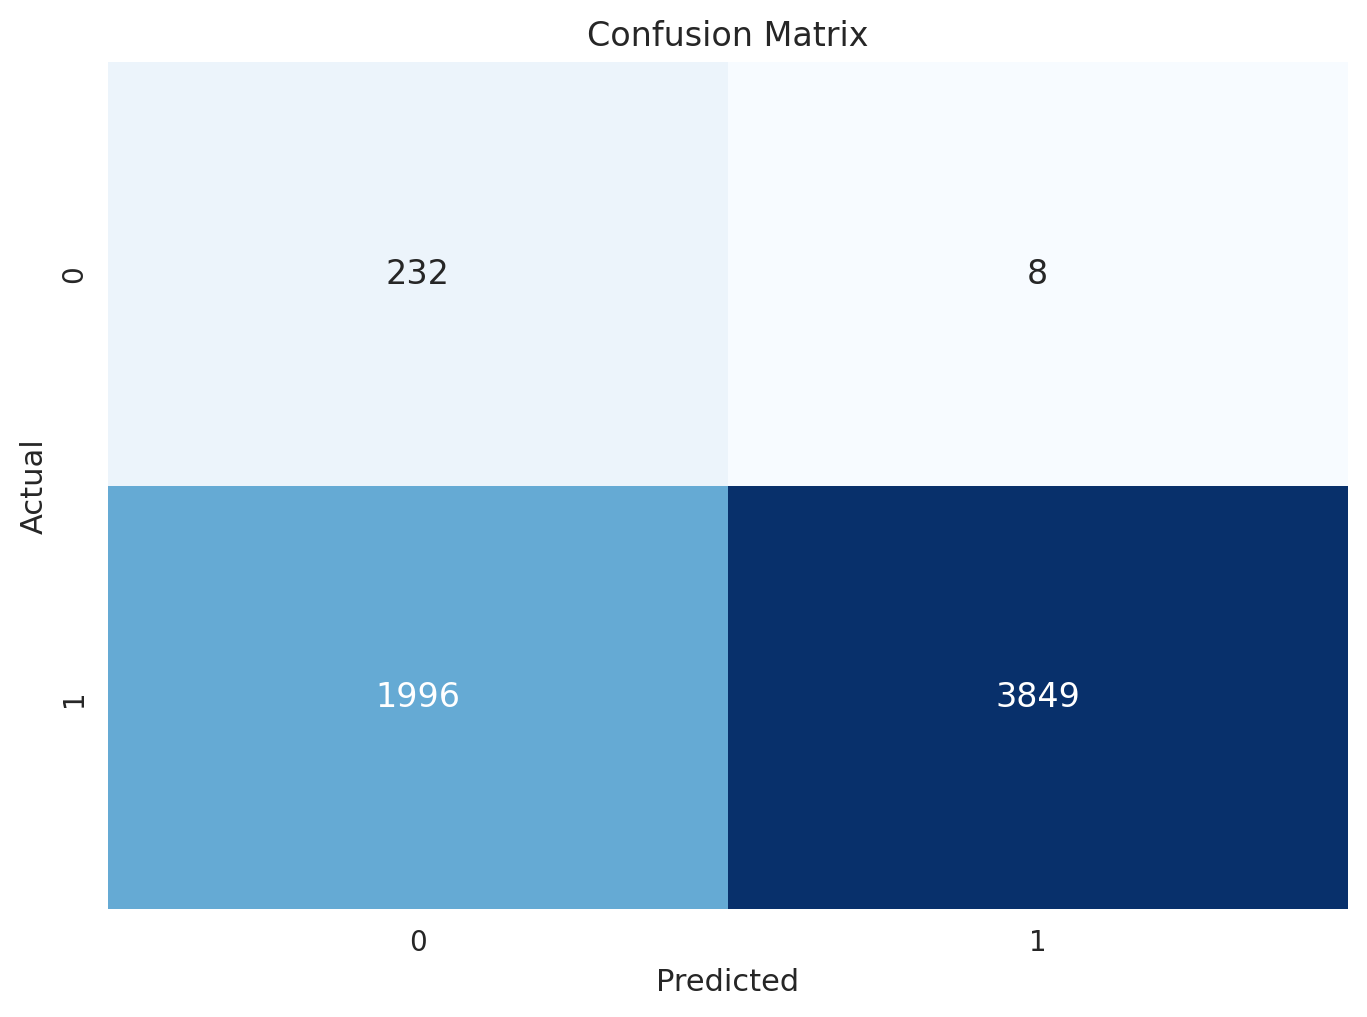

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592


In [36]:
from sklearn.naive_bayes import GaussianNB


# Create a Naive Bayes Classifier (Gaussian Naive Bayes)
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_nb = nb_classifier.predict(X_test)
pred_nb_train = nb_classifier.predict(X_train)

# Evaluate the Naive Bayes model
nb_res = evaluate_preds(y_test, pred_nb, 'NaiveBayes')


# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing._append(pd.Series(nb_res), ignore_index=True)
testing

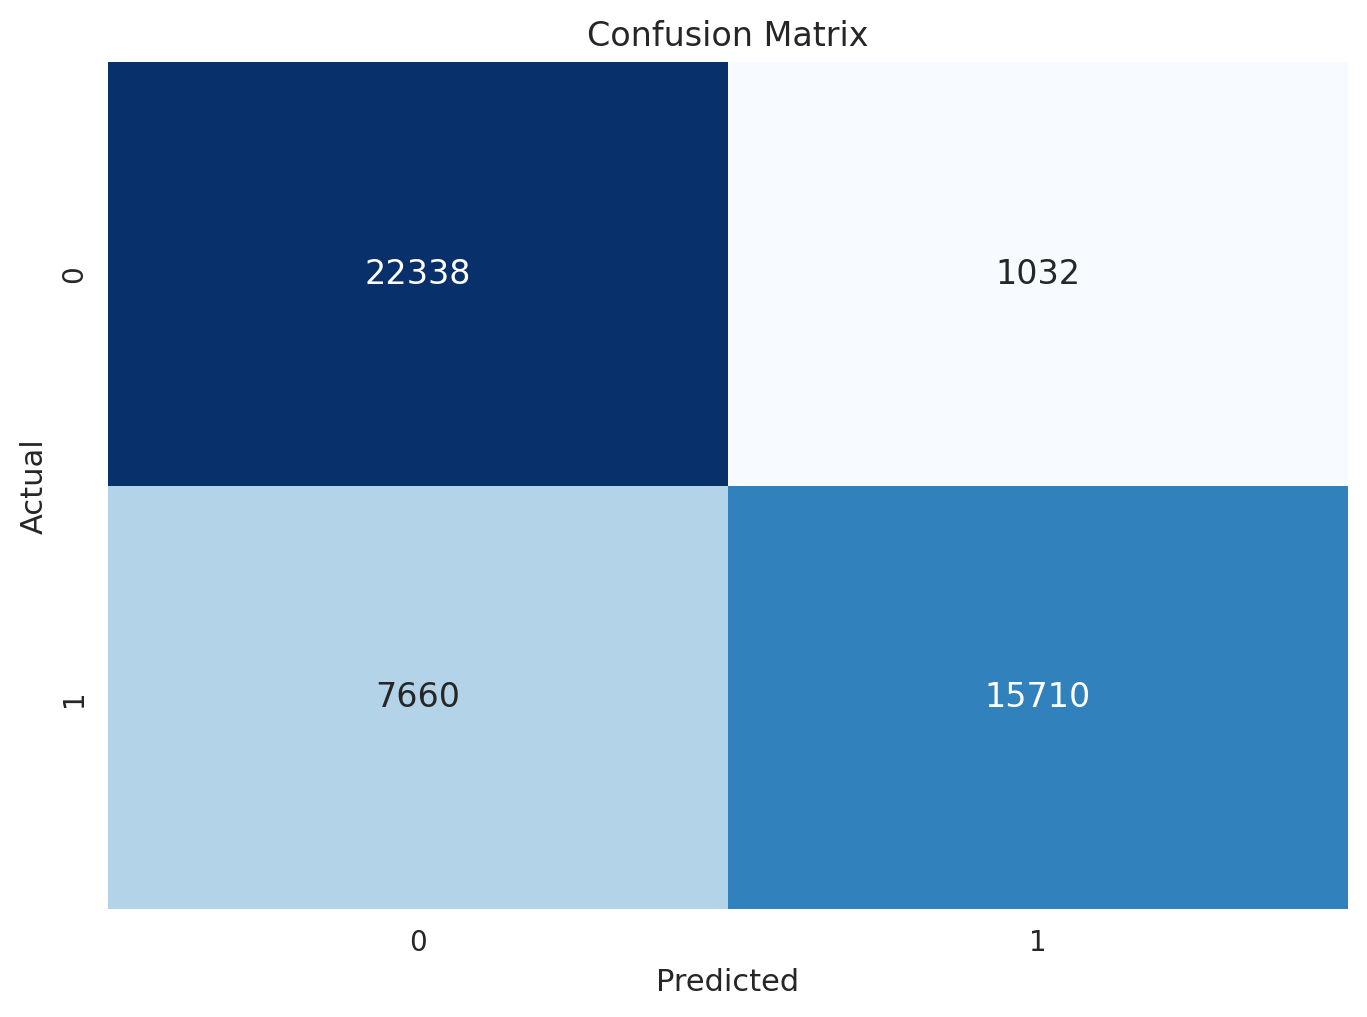

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000
2,NaiveBayes,0.783307,0.654963


In [37]:
nb_res=evaluate_preds(y_train, pred_nb_train, 'NaiveBayes')
training = training._append(pd.Series(nb_res),ignore_index=True )
training

In [38]:
nb_proba=nb_classifier.predict_proba(X)
calculate_apfd_from_probabilities(nb_proba)

0.9999437934763769

#### xgboost

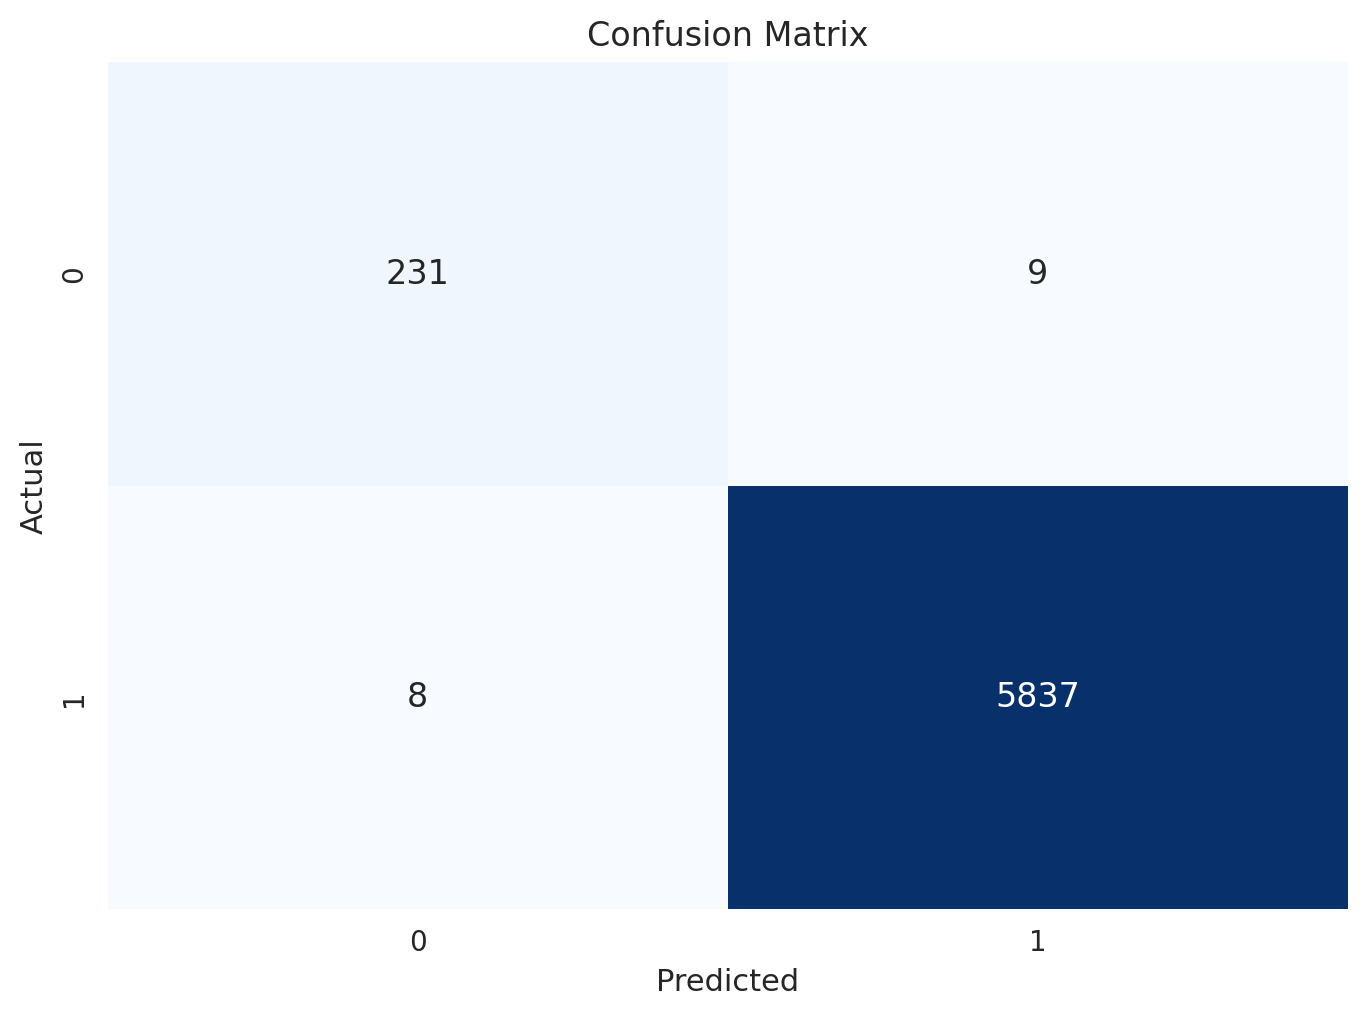

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592
3,XGBoost,0.998546,0.963058


In [39]:
import xgboost as xgb

# Create a XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_xgb = xgb_classifier.predict(X_test)
pred_xgb_train = xgb_classifier.predict(X_train)

# Evaluate the XGBoost model
xgb_res = evaluate_preds(y_test, pred_xgb, 'XGBoost')


# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing._append(pd.Series(xgb_res), ignore_index=True)
testing

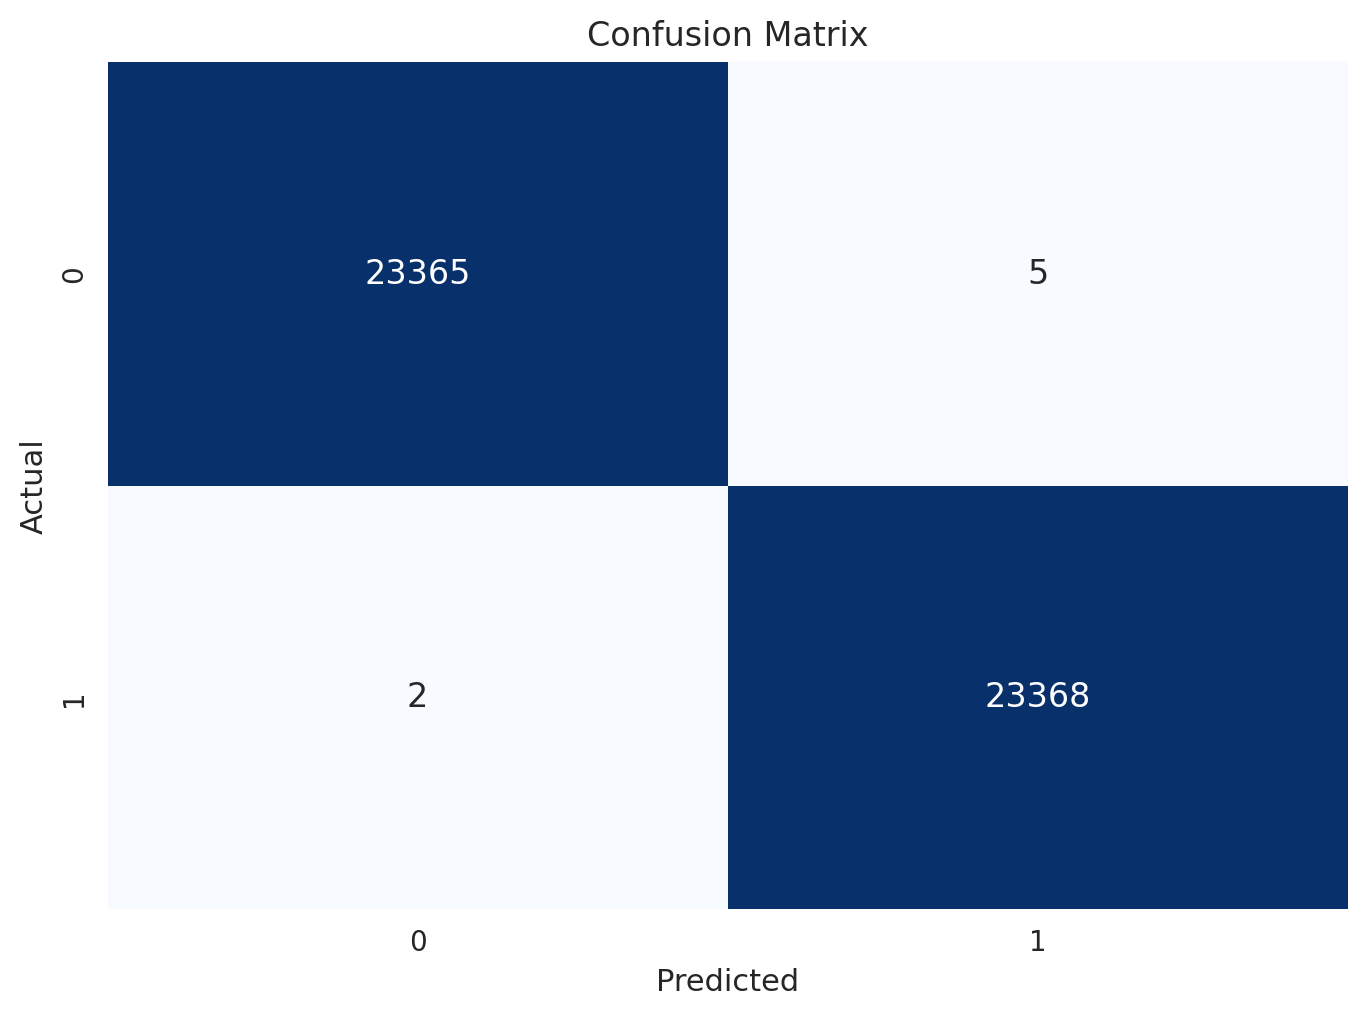

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000
2,NaiveBayes,0.783307,0.654963
3,XGBoost,0.999850,0.999700


In [40]:
xgb_res = evaluate_preds(y_train, pred_xgb_train, 'XGBoost')
training = training._append(pd.Series(xgb_res),ignore_index=True )
training

In [41]:
xgb_proba=xgb_classifier.predict_proba(X)
calculate_apfd_from_probabilities(xgb_proba)

0.9999645278081103

Learning rate set to 0.053197
0:	learn: 0.5762426	total: 40.2ms	remaining: 40.2s
50:	learn: 0.0283947	total: 1.6s	remaining: 29.8s
100:	learn: 0.0180690	total: 3.03s	remaining: 27s
150:	learn: 0.0134621	total: 4.58s	remaining: 25.8s
200:	learn: 0.0114266	total: 5.92s	remaining: 23.5s
250:	learn: 0.0104437	total: 7.24s	remaining: 21.6s
300:	learn: 0.0098312	total: 8.41s	remaining: 19.5s
350:	learn: 0.0098312	total: 9.42s	remaining: 17.4s
400:	learn: 0.0098312	total: 10.4s	remaining: 15.6s
450:	learn: 0.0098312	total: 11.4s	remaining: 13.9s
500:	learn: 0.0098312	total: 12.5s	remaining: 12.4s
550:	learn: 0.0098312	total: 13.5s	remaining: 11s
600:	learn: 0.0098312	total: 14.6s	remaining: 9.67s
650:	learn: 0.0097733	total: 15.6s	remaining: 8.37s
700:	learn: 0.0092913	total: 16.8s	remaining: 7.18s
750:	learn: 0.0090381	total: 17.9s	remaining: 5.95s
800:	learn: 0.0090380	total: 19s	remaining: 4.71s
850:	learn: 0.0090380	total: 20s	remaining: 3.5s
900:	learn: 0.0090380	total: 21s	remaining: 2.

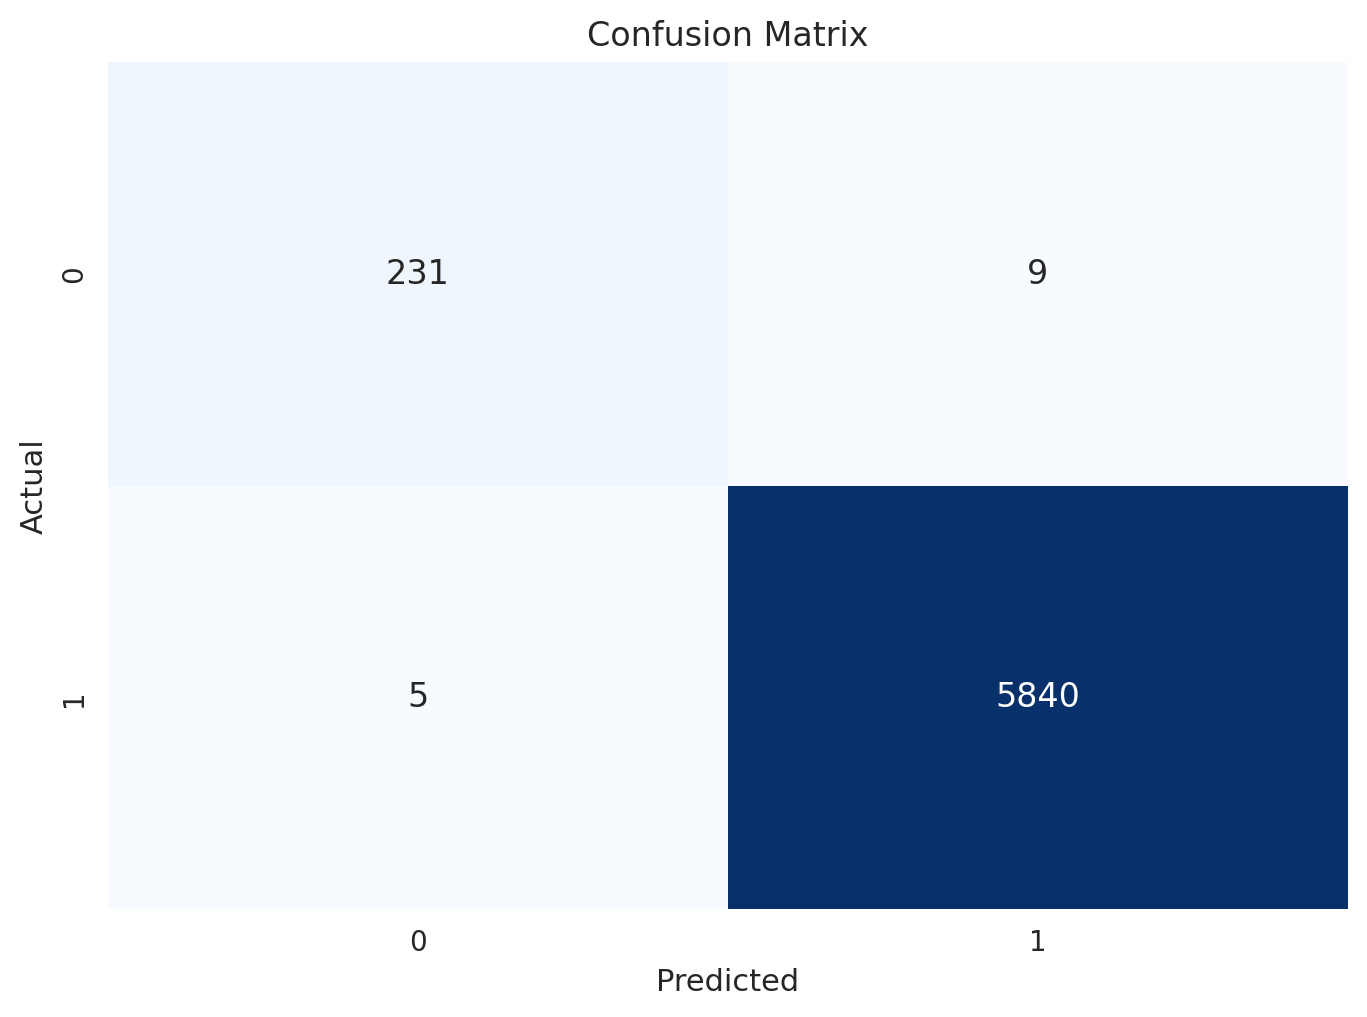

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592
3,XGBoost,0.998546,0.963058
4,CatBoost,0.998803,0.969428


In [42]:
import catboost as cb

# Create a CatBoost Classifier
catboost_classifier = cb.CatBoostClassifier(random_state=42)
catboost_classifier.fit(X_train, y_train,verbose=50)

# Make predictions on the test set
pred_catboost = catboost_classifier.predict(X_test)
pred_catboost_train = catboost_classifier.predict(X_train)

# Evaluate the CatBoost model
catboost_res = evaluate_preds(y_test, pred_catboost, 'CatBoost')

# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing.append(pd.Series(catboost_res), ignore_index=True)
testing


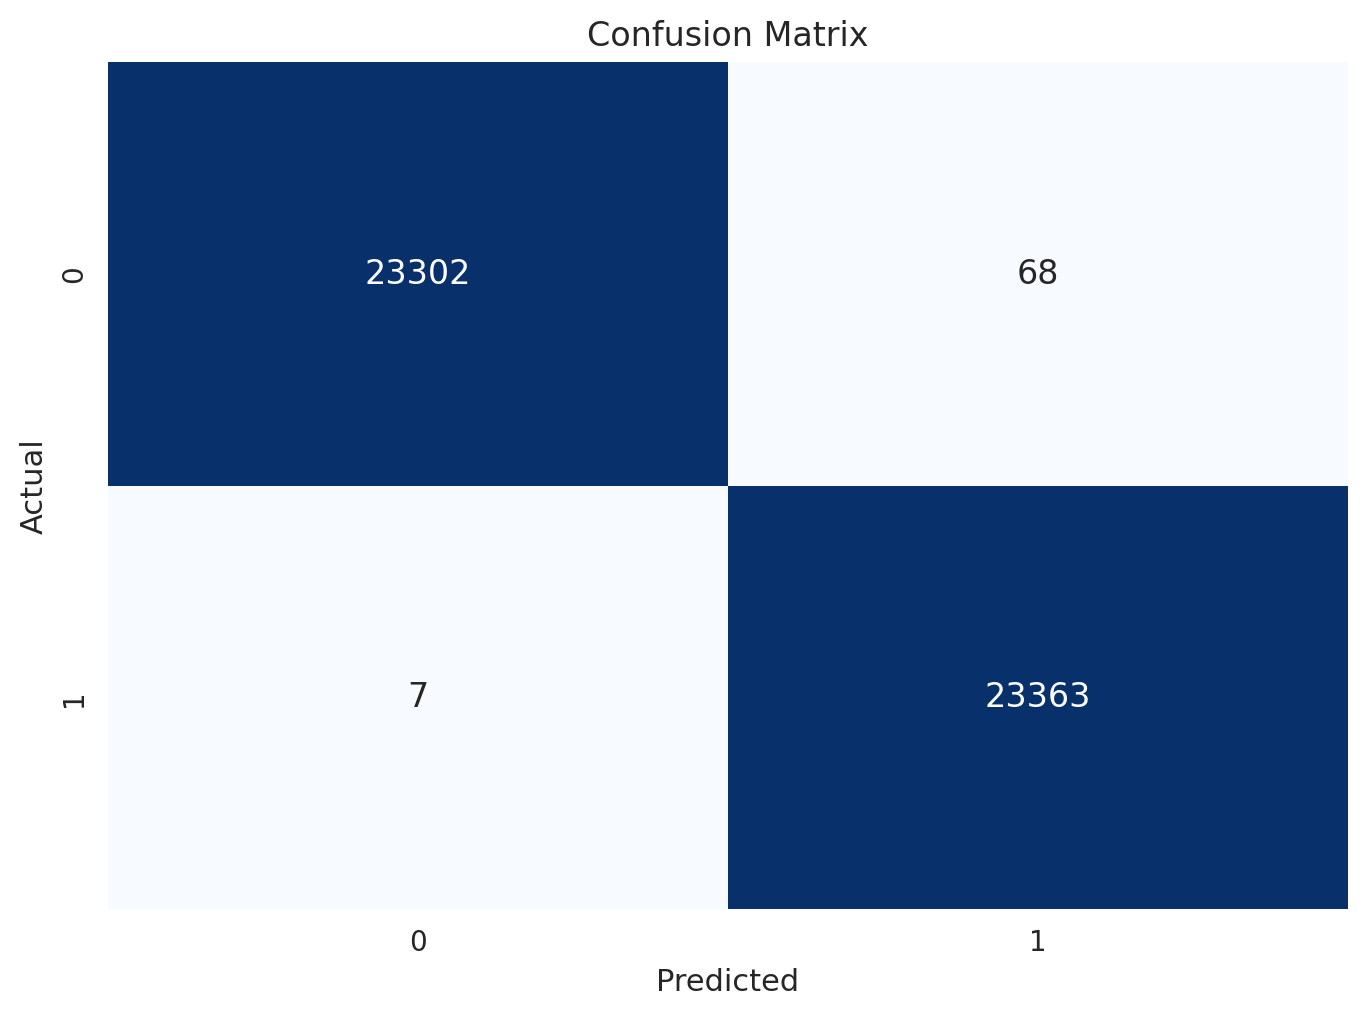

,model,F1 Score,MCC
0,LogisticRegression,0.979182,0.958201
1,RandomForest,1.000000,1.000000
2,NaiveBayes,0.783307,0.654963
3,XGBoost,0.999850,0.999700
4,catboost,0.998397,0.996794


In [43]:
cat_res = evaluate_preds(y_train, pred_catboost_train, 'catboost')
training = training._append(pd.Series(cat_res),ignore_index=True )
training

#### ligtgbm

[LightGBM] [Info] Number of positive: 23370, number of negative: 23370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16285
[LightGBM] [Info] Number of data points in the train set: 46740, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


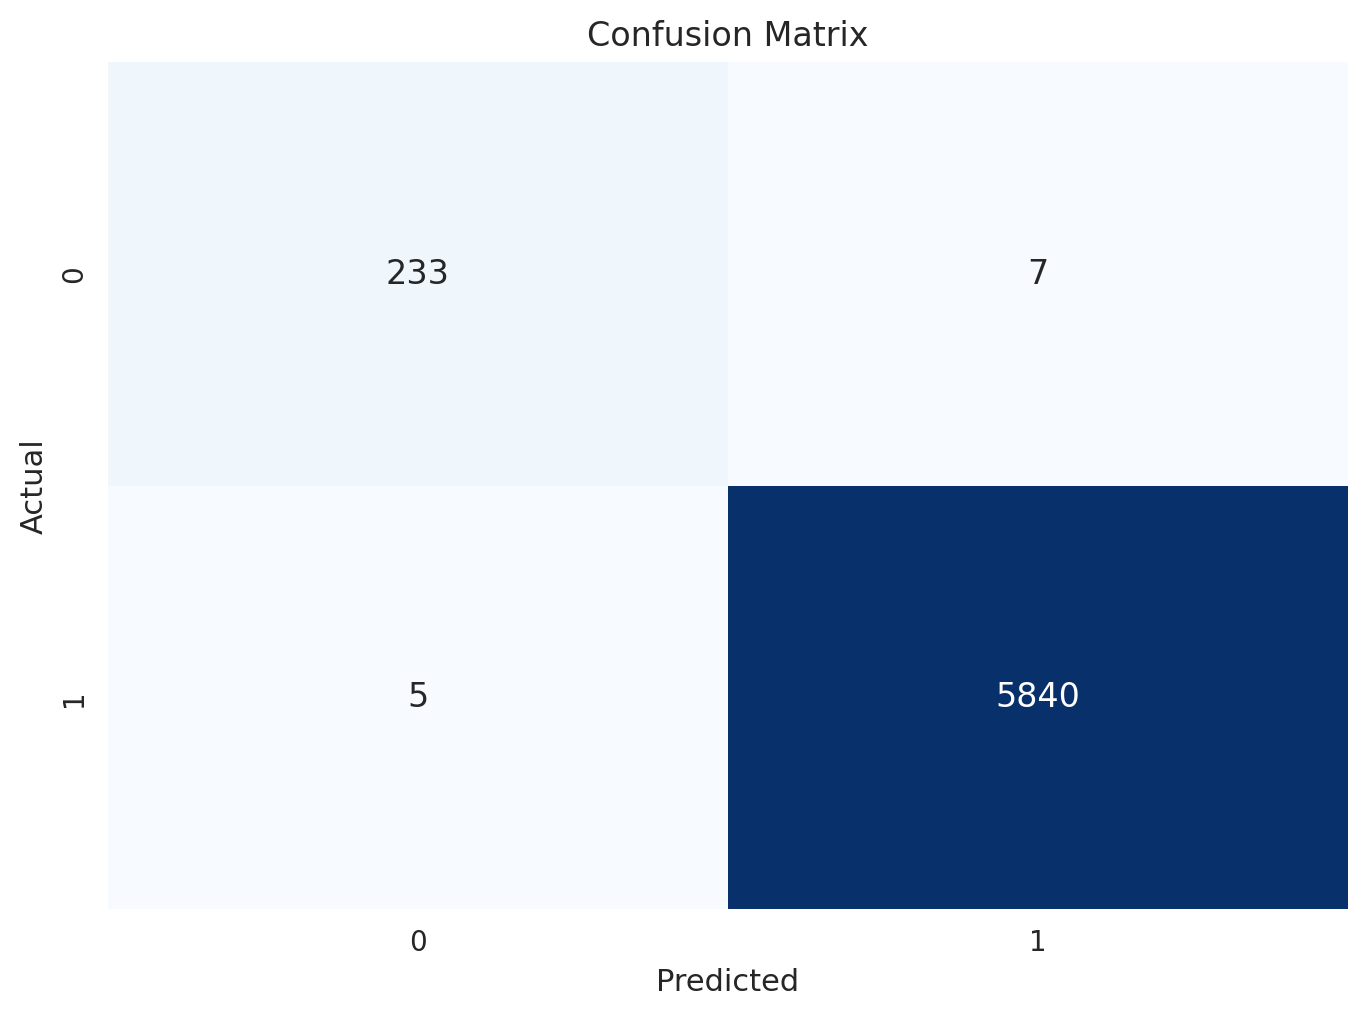

In [44]:
import lightgbm as lgb
# Create a LightGBM Classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
pred_lgb = lgb_classifier.predict(X_test)
pred_lgb_train = lgb_classifier.predict(X_train)

# Evaluate the LightGBM model
lgb_res = evaluate_preds(y_test, pred_lgb, 'LightGBM')

# Append the results to the testing DataFrame (assuming `testing` is a DataFrame)
testing = testing.append(pd.Series(lgb_res), ignore_index=True)

In [45]:
testing

,model,F1 Score,MCC
0,LogisticRegression,0.991646,0.827407
1,RandomForest,0.998717,0.967197
2,NaiveBayes,0.793445,0.252592
3,XGBoost,0.998546,0.963058
4,CatBoost,0.998803,0.969428
5,LightGBM,0.998974,0.973878


[LightGBM] [Info] Number of positive: 23370, number of negative: 970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18945
[LightGBM] [Info] Number of data points in the train set: 24340, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.960148 -> initscore=3.181912
[LightGBM] [Info] Start training from score 3.181912


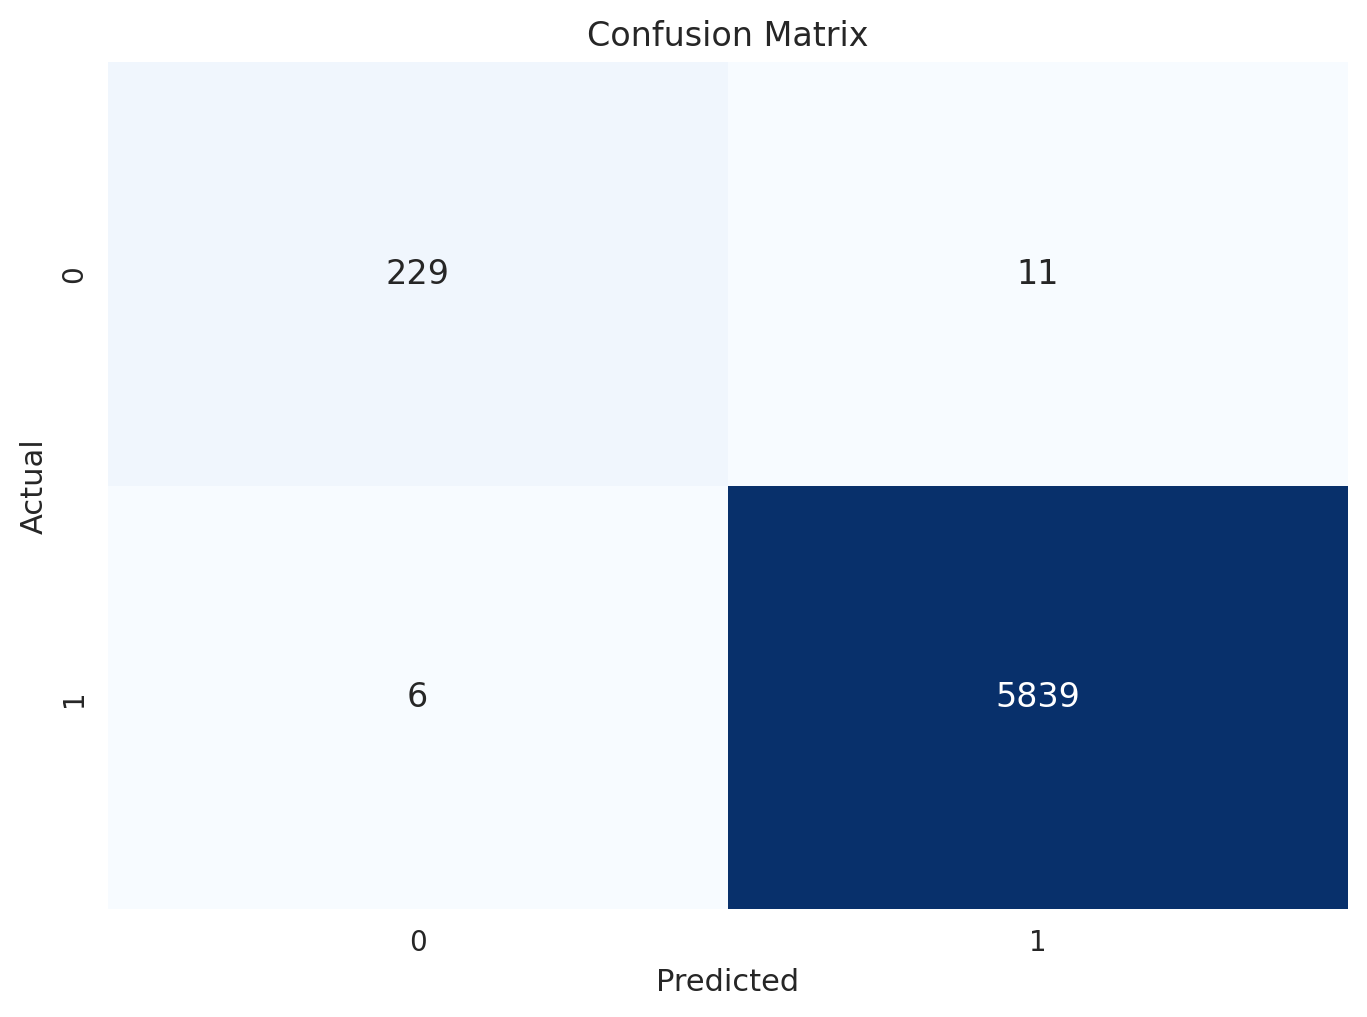

{'model': 'LightGBM',
 'F1 Score': 0.9985463873450192,
 'MCC': 0.9628148450189157}

In [46]:
# compare without sote and feature selection
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
data.drop('Verdict',axis=1), data['Verdict'], test_size=0.2, random_state=42)

lgb_classifier = lgb.LGBMClassifier(random_state=42)
lgb_classifier.fit(Xf_train, yf_train)

# Make predictions on the test set
pred_lgb = lgb_classifier.predict(Xf_test)
pred_lgb_train = lgb_classifier.predict(Xf_train)

# Evaluate the LightGBM model
lgb_res = evaluate_preds(y_test, pred_lgb, 'LightGBM')
lgb_res

### hyperparameter tuning

In [47]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity':-1,
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = matthews_corrcoef(y_val, y_pred)
    return accuracy

def optimize_lgbm(X, y, n_trials=100):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    study = optuna.create_study(direction='maximize')
    objective_fn = lambda trial: objective(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective_fn, n_trials=n_trials)

    best_params = study.best_params
    best_model = lgb.LGBMClassifier(**best_params)
    best_model.fit(X_train, y_train)

    return best_model, best_params

In [48]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
best_model, best_params = optimize_lgbm(X_resampled, y_resampled, n_trials=1000)
best_params

[I 2024-02-17 18:13:27,477] A new study created in memory with name: no-name-d7c2b6ee-23f4-4909-87a6-6af1ef3f8910
[I 2024-02-17 18:13:34,044] Trial 0 finished with value: 0.9965787153852581 and parameters: {'num_leaves': 168, 'learning_rate': 0.046029140679866194, 'feature_fraction': 0.7141813129357208, 'bagging_fraction': 0.6460191698370102, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 0 with value: 0.9965787153852581.
[I 2024-02-17 18:13:40,364] Trial 1 finished with value: 0.9835673037365629 and parameters: {'num_leaves': 940, 'learning_rate': 0.0033114254951832596, 'feature_fraction': 0.12312865291877419, 'bagging_fraction': 0.9693385795347187, 'bagging_freq': 6, 'min_child_samples': 50}. Best is trial 0 with value: 0.9965787153852581.
[I 2024-02-17 18:13:46,441] Trial 2 finished with value: 0.9773111935780628 and parameters: {'num_leaves': 363, 'learning_rate': 0.0013858543476006242, 'feature_fraction': 0.9246504091093536, 'bagging_fraction': 0.5287880437322237, 'bag

[LightGBM] [Warning] feature_fraction is set=0.9215403443362944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215403443362944
[LightGBM] [Warning] bagging_fraction is set=0.8142683548735626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8142683548735626
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9215403443362944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9215403443362944
[LightGBM] [Warning] bagging_fraction is set=0.8142683548735626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8142683548735626
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 23448, number of negative: 23296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032750 seconds.
You can

{'num_leaves': 436,
 'learning_rate': 0.09817044451938046,
 'feature_fraction': 0.9215403443362944,
 'bagging_fraction': 0.8142683548735626,
 'bagging_freq': 3,
 'min_child_samples': 24}

In [49]:
best_params

{'num_leaves': 436,
 'learning_rate': 0.09817044451938046,
 'feature_fraction': 0.9215403443362944,
 'bagging_fraction': 0.8142683548735626,
 'bagging_freq': 3,
 'min_child_samples': 24}